In [1]:
!python3 --version

Python 3.7.15


In [2]:
# %load_ext lab_black
%load_ext autoreload
%autoreload 2

In [53]:
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
# import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import gc

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
DATA_DIR = ''#Path.cwd().parent.resolve() / "data/final/public"
# DATA_DIR = '/gdrive/My Drive/Colab Notebooks/HarmfulAlgalBloomDetection/'#Path.cwd().parent.resolve() / "data/final/public"
# assert DATA_DIR.exists()

In [5]:
metadata = pd.read_csv(DATA_DIR + "metadata.csv")
metadata.head()

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


In [6]:
len(metadata.uid.unique())

23570

In [7]:
len(metadata.loc[:,['latitude','longitude' 	]].drop_duplicates())

12681

In [8]:
duplicated_rows=np.where(metadata.loc[:,['latitude','longitude']].duplicated()==True)[0]
duplicated_rows

array([   79,   106,   107, ..., 23565, 23566, 23569])

In [9]:
metadata.iloc[duplicated_rows[0],:]

uid                acdj
latitude        37.3906
longitude      -120.958
date         2015-04-14
split             train
Name: 79, dtype: object

In [10]:
metadata.loc[metadata['latitude']==metadata.latitude.iloc[duplicated_rows[0]],:].head()

,uid,latitude,longitude,date,split
22,aaqc,37.3906,-120.958,2013-07-09,train
79,acdj,37.3906,-120.958,2015-04-14,train
1701,bxeq,37.3906,-120.958,2019-09-10,train
2302,conk,37.3906,-120.958,2019-12-04,train
2409,crja,37.3906,-120.958,2021-07-13,train


In [11]:
metadata.split.value_counts(dropna=False)

train    17060
test      6510
Name: split, dtype: int64

In [12]:
# convert date to pd.datetime
metadata.date = pd.to_datetime(metadata.date)

# what is the date range?
metadata.groupby("split").agg(min_date=("date", min), max_date=("date", max))

,min_date,max_date
split,,
test,2013-01-08,2021-12-29
train,2013-01-04,2021-12-14


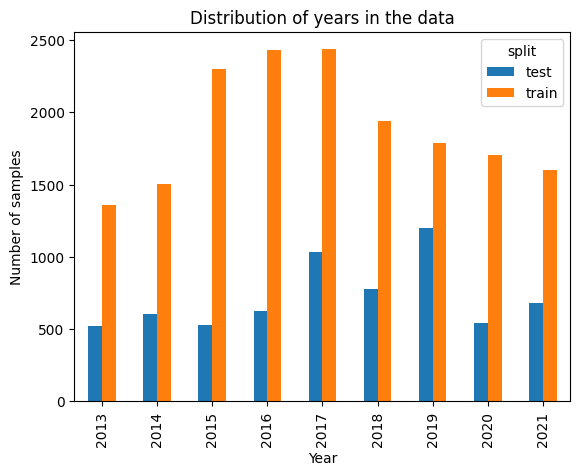

In [13]:
# what years are in the data?
pd.crosstab(metadata.date.dt.year, metadata.split).plot(kind="bar")
plt.ylabel("Number of samples")
plt.xlabel("Year")
plt.title("Distribution of years in the data")
plt.show()

In [14]:
# what seasons are the data points from?

metadata["season"] = (
    metadata.date.dt.month.replace([12, 1, 2], "winter")
    .replace([3, 4, 5], "spring")
    .replace([6, 7, 8], "summer")
    .replace([9, 10, 11], "fall")
)
metadata.season.value_counts()

summer    10813
spring     5045
fall       4758
winter     2954
Name: season, dtype: int64

In [15]:
train_labels = pd.read_csv(DATA_DIR + "train_labels.csv")
train_labels.head()

,uid,region,severity,density
0,aabm,midwest,1,585.0
1,aacd,south,1,290.0
2,aaee,south,1,1614.0
3,aaff,midwest,3,111825.0
4,aafl,midwest,4,2017313.0


In [16]:
train_labels.shape

(17060, 4)

In [17]:
train_labels_and_metadata = train_labels.merge(
    metadata, how="left", left_on="uid", right_on="uid", validate="1:1"
)

Text(0.5, 1.0, 'Train labels severity level counts')

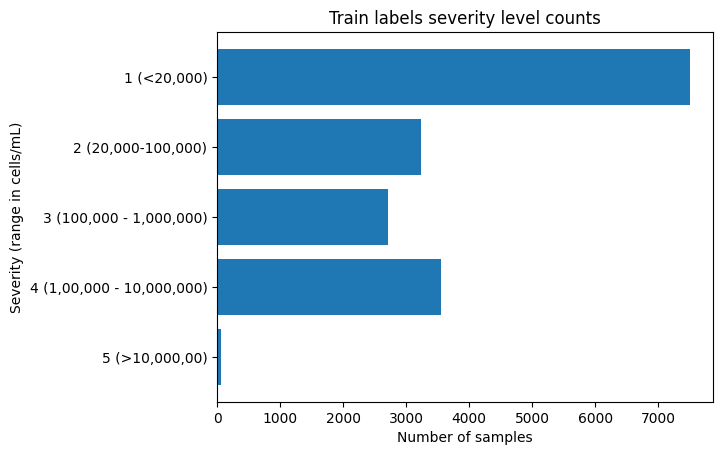

In [18]:
severity_counts = (
    train_labels.replace(
        {
            "severity": {
                1: "1 (<20,000)",
                2: "2 (20,000-100,000)",
                3: "3 (100,000 - 1,000,000)",
                4: "4 (1,00,000 - 10,000,000)",
                5: "5 (>10,000,00)",
            }
        }
    )
    .severity.value_counts()
    .sort_index(ascending=False)
)
plt.barh(severity_counts.index, severity_counts.values)
plt.xlabel("Number of samples")
plt.ylabel("Severity (range in cells/mL)")
plt.title("Train labels severity level counts")

In [19]:
train_labels.density.describe()

count    1.706000e+04
mean     1.074537e+06
std      6.836693e+06
min      0.000000e+00
25%      4.066000e+03
50%      3.270975e+04
75%      4.849192e+05
max      8.046675e+08
Name: density, dtype: float64

In [20]:
(train_labels.density == 0).sum()

91

In [21]:
metadata.shape,train_labels.shape

((23570, 6), (17060, 4))

In [22]:
#ADD train labels to metadata

metadata=metadata.merge(train_labels,on='uid',how='left')
metadata.loc[:,['severity','density']]=metadata.loc[:,['severity','density']].fillna(-1)

In [24]:
metadata.head()

,uid,latitude,longitude,date,split,season,region,severity,density
0,aabm,39.080319,-86.430867,2018-05-14,train,spring,midwest,1.0,585.0
1,aabn,36.559700,-121.510000,2016-08-31,test,summer,NaN,-1.0,-1.0
2,aacd,35.875083,-78.878434,2020-11-19,train,fall,south,1.0,290.0
3,aaee,35.487000,-79.062133,2016-08-24,train,summer,south,1.0,1614.0
4,aaff,38.049471,-99.827001,2019-07-23,train,summer,midwest,3.0,111825.0


In [25]:
submission_format = pd.read_csv(DATA_DIR + "submission_format.csv", index_col=0)
submission_format.head()

,region,severity
uid,,
aabn,west,1
aair,west,1
aajw,northeast,1
aalr,midwest,1
aalw,west,1


In [26]:
submission_format.shape

(6510, 2)

In [27]:
metadata.shape

(23570, 9)

In [28]:
len(submission_format)+len(train_labels)-len(metadata)


0

In [29]:
example_row = metadata[metadata.uid == "garm"].iloc[0]
example_row

uid                         garm
latitude                41.98006
longitude             -110.65734
date         2021-09-27 00:00:00
split                      train
season                      fall
region                      west
severity                     5.0
density              12267752.74
Name: 5461, dtype: object

In [30]:
def image_to_features(image_array):
    """
    Convert an image array of the form (color band, height, width) to a
    1-dimensional list of features. Returns a list where the first three
    values are the averages of each color band, and the second three
    values are the medians of each color band.
    """
    averages = image_array.mean(axis=(1, 2)).tolist()
    medians = np.median(image_array, axis=(1, 2)).tolist()
    stds = np.std(image_array, axis=(1, 2)).tolist()

    # c0 = int(image_array.shape[1]/2)
    # c1 = int(image_array.shape[1]/2)
    # averages_zoomin = image_array[:,c0-1:c0+1,c1-1:c1+1].mean(axis=(1, 2)).tolist()
    # medians_zoomin = np.median(image_array[:,c0-1:c0+1,c1-1:c1+1], axis=(1, 2)).tolist()

    return averages + medians + stds #+averages_zoomin + medians_zoomin

In [31]:
# take a random subset of the training data for the benchmark
# train_subset = metadata[metadata["split"] == "train"].sample(n=2500, random_state=2)
train_subset = metadata[metadata["split"] == "train"]

# combine train subset with all test data
metadata_subset = pd.concat([train_subset, metadata[metadata["split"] == "test"]])
metadata_subset.split.value_counts(dropna=False)

train    17060
test      6510
Name: split, dtype: int64

In [32]:
# np.abs(altDF.altitude-altDF.altitude.astype(int)).sum()

In [33]:
#to be used in group kfold split

metadata['latlong']=metadata['latitude'].round(2).astype(str)+'_'+metadata['longitude'].round(2).astype(str)
metadata['latlong1']=metadata['latitude'].round(1).astype(str)+'_'+metadata['longitude'].round(1).astype(str)
metadata['latlong0']=metadata['latitude'].round(0).astype(str)+'_'+metadata['longitude'].round(0).astype(str)
metadata['latlong10']=metadata['latitude'].round(1).astype(str)+'_'+metadata['longitude'].round(0).astype(str)
unique_points=np.unique(metadata.latlong)
unique_points1=np.unique(metadata.latlong1)
unique_points0=np.unique(metadata.latlong0)
unique_points10=np.unique(metadata.latlong10)
# metadata.head()

In [34]:
# metadata.shape,altDF.shape

In [35]:
# #GET geomorhological features
# DEM_DATA_DIR = "benchmark/dem/"#DATA_DIR.parents[1] / "benchmark"
# DEM_DATA_DIR = "benchmark/dem2K/"#DATA_DIR.parents[1] / "benchmark"
# geomorthology_files=os.listdir(DEM_DATA_DIR)
# len(geomorthology_files),geomorthology_files[0]

(23556, 'oeuw_alt123.jpg')

In [340]:


# # RESIZE_SIZE=128
# DEM_RESIZE_SIZE=32
# dem_featuresL=[]
# rgbDEM=[]
# for f in tqdm(geomorthology_files):
# # for row in tqdm(metadata_subset.iloc[:2,:].itertuples(), total=2):
#     im = cv2.imread(DEM_DATA_DIR+f, cv2.IMREAD_GRAYSCALE)

#     dem_features = image_to_features(np.expand_dims(im,0))
#     dem_featuresL.append(dem_features)
#     if im.max()!=im.min():
#         im=(im-im.min())/(im.max()-im.min())
#     else:
#         im*=0
#     im=cv2.resize(im,(DEM_RESIZE_SIZE, DEM_RESIZE_SIZE))
#     rgbDEM.append((im*255).astype('uint8'))
        
# rgbDEM=np.stack(rgbDEM)    
# dem_featuresL=np.stack(dem_featuresL)    
# # np.savez_compressed('dem2K', a=rgbDEM, b=dem_featuresL)
# dem_featuresL.shape
# geo_uids=[x.split('_')[0] for x in geomorthology_files]
# geo_alts=[int(x.split('_')[1].split('.')[0][3:]) for x in geomorthology_files]
# geo_uids[:5],geo_alts[:5]

In [339]:

temp=np.load('dem2K.npz')
rgbDEM=temp['a']
dem_featuresL=temp['b']
geo_uids=temp['c']
geo_alts=temp['d']
geo_uids[:5],geo_alts[:5]

(array(['oeuw', 'tjhp', 'crel', 'zqhi', 'estg'], dtype='<U4'),
 array([123,  19,   8,  85,  -4]))

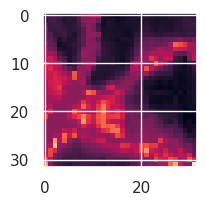

In [341]:
plt.figure(figsize=(2,2))
plt.imshow(rgbDEM[101])
plt.show()

In [39]:
rgbDEM.shape

(23556, 32, 32)

In [40]:
# altDF=pd.DataFrame(np.stack([[('_').join(x.split('_')[:2]),float(x.split('_')[-1][3:-4])] for x in geomorthology_files]),columns=['latlong','altitude'])
# altDF['altitude']=altDF['altitude'].astype(float)
altDF=pd.DataFrame(geo_uids,columns=['uid'])
altDF['altitude']=geo_alts
altDF['altitude']=altDF['altitude'].fillna(altDF['altitude'].median)

altDF['DEMmean']=dem_featuresL[:,0]
altDF['DEMmedian']=dem_featuresL[:,1]
altDF['DEMstd']=dem_featuresL[:,2]
altDF.head()


,uid,altitude,DEMmean,DEMmedian,DEMstd
0,oeuw,123,108.174279,104.5,47.364784
1,tjhp,19,107.601538,103.0,33.233621
2,crel,8,62.676179,40.0,64.743936
3,zqhi,85,109.822581,105.0,54.010357
4,estg,-4,62.576923,46.0,50.925415


In [41]:
# cv2.imread(DEM_DATA_DIR+f, cv2.IMREAD_GRAYSCALE).shape

(26, 32)

In [42]:
gc.collect()

7446

In [45]:
# LOAD CLIMATOLOGICAL DATA

temp=np.load('climate_d28_b5000.npz') # temperature 4 weeks
climSeries=temp['a']
clim_featuresL=temp['b']
climIds=temp['c']

temp=np.load('climate_d28_b5000w1.npz') # temperature 1 week
clim_featuresLw1=temp['b']
climIdsw1=temp['c']

temp=np.load('climate_rain_d28_b5000.npz')
climSeriesR=temp['a']
clim_featuresR=temp['b']
climIdsR=temp['c']

temp=np.load('climate_gust_d28_b5000.npz')
climSeriesG=temp['a']
clim_featuresG=temp['b']
climIdsG=temp['c']

temp=np.load('climate_snowc_d28_b15000.npz')
climSeriesS=temp['a']
clim_featuresS=temp['b']
climIdsS=temp['c']

temp=np.load('climate_hgt_d28_b15000.npz')
climSeriesH=temp['a']
clim_featuresH=temp['b']
climIdsH=temp['c']

In [46]:
climSeries.shape, climSeriesR.shape, climSeriesG.shape, climSeriesS.shape, climSeriesH.shape,

((20502, 28), (20502, 28), (20502, 28), (20547, 28), (20547, 28))

In [48]:
climIdsSeries=pd.DataFrame(np.concatenate((np.expand_dims(climIds,1),climSeries),1), columns=['uid']+['Temp'+str(i) for i in range(28)])

climIdsSeriesR=pd.DataFrame(np.concatenate((np.expand_dims(climIdsR,1),climSeriesR),1), columns=['uid']+['Rain'+str(i) for i in range(28)])

climIdsSeriesG=pd.DataFrame(np.concatenate((np.expand_dims(climIdsG,1),climSeriesG),1), columns=['uid']+['Gust'+str(i) for i in range(28)])

climIdsSeriesS=pd.DataFrame(np.concatenate((np.expand_dims(climIdsS,1),climSeriesS),1), columns=['uid']+['Snowc'+str(i) for i in range(28)])

climIdsSeriesH=pd.DataFrame(np.concatenate((np.expand_dims(climIdsH,1),climSeriesH),1), columns=['uid']+['HGT'+str(i) for i in range(28)])



In [49]:
climIds.shape,clim_featuresL.shape


((20502,), (20502, 3))

In [54]:
clim_featuresDF=pd.concat([pd.DataFrame(clim_featuresL,columns=['climate_mean','climate_median','climate_std']),
                           pd.DataFrame(climIds,columns=['uid'])],1)
clim_featuresDF.head()

,climate_mean,climate_median,climate_std,uid
0,15.510000,14.72,2.891339,waln
1,19.679286,19.53,3.257052,wlwd
2,23.263571,23.54,2.815118,zxdf
3,11.067143,11.58,2.001658,rzcf
4,27.039286,27.98,3.080568,djsa


In [55]:
clim_featuresW1DF=pd.concat([pd.DataFrame(clim_featuresLw1,columns=['climate_mean_fw','climate_median_fw','climate_std_fw']),
                           pd.DataFrame(climIdsw1,columns=['uid'])],1)
clim_featuresW1DF.head()

,climate_mean_fw,climate_median_fw,climate_std_fw,uid
0,15.577143,14.40,3.785377,waln
1,18.914286,18.52,3.163031,wlwd
2,20.622857,20.52,2.451622,zxdf
3,11.360000,11.72,2.610134,rzcf
4,26.665714,26.48,1.777662,djsa


In [56]:
clim_featuresRDF=pd.concat([pd.DataFrame(clim_featuresR,columns=['rain_mean','rain_median','rain_std']),
                           pd.DataFrame(climIdsR,columns=['uid'])],1)
clim_featuresRDF.head()

,rain_mean,rain_median,rain_std,uid
0,0.181429,0.0,0.381947,waln
1,0.212143,0.0,0.378166,wlwd
2,0.092857,0.0,0.267059,zxdf
3,0.060000,0.0,0.180317,rzcf
4,0.100714,0.0,0.268088,djsa


In [57]:
clim_featuresRDF[['rain_median']].value_counts()

rain_median
0.000000       19695
1.000000         134
0.040000          91
0.020000          56
0.060000          40
               ...  
0.266667           1
0.490000           1
0.220000           1
0.140000           1
0.441667           1
Length: 107, dtype: int64

In [58]:
clim_featuresGDF=pd.concat([pd.DataFrame(clim_featuresG,columns=['gust_mean','gust_median','gust_std']),
                           pd.DataFrame(climIdsG,columns=['uid'])],1)
clim_featuresGDF.head()

,gust_mean,gust_median,gust_std,uid
0,6.577143,6.62,2.962208,waln
1,5.080714,5.42,2.294039,wlwd
2,3.024286,2.26,2.655266,zxdf
3,1.992857,1.90,1.157734,rzcf
4,4.527857,4.50,2.498653,djsa


In [59]:
clim_featuresSDF=pd.concat([pd.DataFrame(clim_featuresS,columns=['snowc_mean','snowc_median','snowc_std']),
                           pd.DataFrame(climIdsS,columns=['uid'])],1)
clim_featuresSDF.head()
clim_featuresHDF=pd.concat([pd.DataFrame(clim_featuresH,columns=['hgt_mean','hgt_median','hgt_std']),
                           pd.DataFrame(climIdsH,columns=['uid'])],1)
clim_featuresHDF.head()

,hgt_mean,hgt_median,hgt_std,uid
0,120.442308,120.442308,0.000000e+00,waln
1,109.023669,109.023669,2.842171e-14,wlwd
2,309.899408,309.899408,0.000000e+00,zxdf
3,484.071429,484.071429,1.705303e-13,rzcf
4,161.089744,161.089744,2.842171e-14,djsa


In [330]:
# plt.hist(clim_featuresGDF.gust_mean,50)
# plt.hist(clim_featuresGDF.gust_median,50)
# plt.show()
# plt.hist(clim_featuresGDF.gust_std,50)
# plt.show()

In [61]:
metadata=metadata.merge(altDF,how='left').fillna(-1)
metadata.head()

,uid,latitude,longitude,date,split,season,region,severity,density,latlong,latlong1,latlong0,latlong10,altitude,DEMmean,DEMmedian,DEMstd
0,aabm,39.080319,-86.430867,2018-05-14,train,spring,midwest,1.0,585.0,39.08_-86.43,39.1_-86.4,39.0_-86.0,39.1_-86.0,169.0,61.069930,22.5,68.402346
1,aabn,36.559700,-121.510000,2016-08-31,test,summer,-1,-1.0,-1.0,36.56_-121.51,36.6_-121.5,37.0_-122.0,36.6_-122.0,30.0,62.063702,40.0,53.451200
2,aacd,35.875083,-78.878434,2020-11-19,train,fall,south,1.0,290.0,35.88_-78.88,35.9_-78.9,36.0_-79.0,35.9_-79.0,94.0,130.127404,133.0,44.633880
3,aaee,35.487000,-79.062133,2016-08-24,train,summer,south,1.0,1614.0,35.49_-79.06,35.5_-79.1,35.0_-79.0,35.5_-79.0,129.0,147.151442,152.0,50.721441
4,aaff,38.049471,-99.827001,2019-07-23,train,summer,midwest,3.0,111825.0,38.05_-99.83,38.0_-99.8,38.0_-100.0,38.0_-100.0,702.0,132.240093,131.5,52.735658


In [62]:
dem_featuresL.shape,im.shape
dem_featuresL

array([[108.17427885, 104.5       ,  47.36478388],
       [107.60153846, 103.        ,  33.23362057],
       [ 62.67617866,  40.        ,  64.74393619],
       ...,
       [ 82.21153846,  78.        ,  33.90528325],
       [110.68629808, 116.        ,  56.38459457],
       [107.12379808,  96.        ,  55.43781436]])

In [63]:
gc.collect()

20270

<!--     https://epic.awi.de/id/eprint/49883/1/remotesensing-11-01730.pdf

Band Wavelength (μm) | Resolution (m) | Band Wavelength (μm) | Resolution (m)  

                    |        LANDSAT       |       SENTINEL-2  

    Coastal Aerosol | 1 | 0.45–0.451  | 30 | 1  | 0.430–0.450 | 60

    Blue            | 2 | 0.452–0.51  | 30 | 2  | 0.448–0.546 | 10

    Green           | 3 | 0.533–0.59  | 30 | 3  | 0.538–0.583 | 10

    Red             | 4 | 0.636–0.673 | 30 | 4  | 0.646–0.684 | 10

    NIR             | 5 | 0.851–0.879 | 30 | 8A | 0.848–0.881 | 20

    NIR2                                   | 8 | 0.763–0.908 | 10

    SWIR1           | 6 | 1.566–1.651 | 30 | 11 | 1.542–1.685 | 20

    SWIR2           | 7 | 2.107–2.294 | 30 | 12 | 2.081–2.323 | 20

    Cirrus          | 9 | 1.363–1.384 | 30 | 10 | 1.336–1.441 | 60
 -->

In [64]:
import rasterio
def read_band(path,band='B4'):
    im0=os.listdir(path)[0].split('.')[0]
    b=rasterio.open(path+im0+'.'+band+'.tif' ).read()[0,...]
#     percB = np.percentile(b,[0.1,99.99])
#     b = np.clip(b, percB[0], percB[1])
    B=(((b-b.min())/(b.max()-b.min()))*255).astype('uint8')
    return(B)

TIME_BUFFER_DAYS=20
AREA_BUFFER = 500
CLOUDS_LESS_THAN=30

BASE_DIRs = 'EEtemp/S_t'+str(TIME_BUFFER_DAYS)+'_a'+str(AREA_BUFFER)+'_c'+str(CLOUDS_LESS_THAN)+'/'
BASE_DIRl = 'EEtemp/L_t'+str(TIME_BUFFER_DAYS)+'_a'+str(AREA_BUFFER)+'_c'+str(CLOUDS_LESS_THAN)+'/'

num=1
file = BASE_DIRs+os.listdir(BASE_DIRs)[num]+'/'
# file = BASE_DIRl+os.listdir(BASE_DIRl)[num]+'/'
B4=read_band(file,band='B4')
B3=read_band(file,band='B3')
B2=read_band(file,band='B2')
RGB=np.stack((B4,B3,B2),-1)
RGB.shape

(103, 103, 3)

In [65]:
num=1
file = BASE_DIRl+os.listdir(BASE_DIRl)[num]+'/'
im0=os.listdir(file)[0].split('.')[0]+'.B2.tif'
b=rasterio.open(file+im0 ).read()[0,...]
b.shape

(36, 35)

In [331]:
# plt.imshow(b)
# plt.show()
# # np.unique(b),b.mean(),b[8:-8,8:-8].mean()

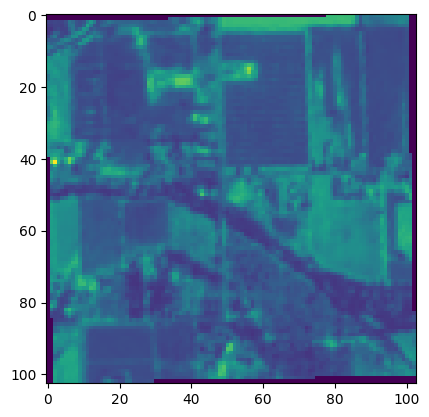

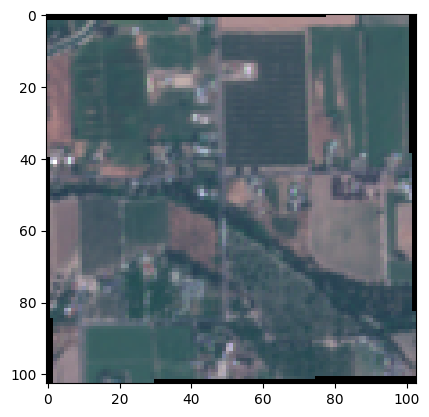

In [67]:
plt.imshow(B4)
plt.show()
plt.imshow(RGB)
plt.show()

In [85]:
# RESIZE_SIZE=64
# BASE_DIR=BASE_DIRs

# rgbsS=[]
# idsS=[]

# # for uid in tqdm(os.listdir(BASE_DIR)[:200], total=200):
# for uid in tqdm(os.listdir(BASE_DIR)):

#     file = BASE_DIR+uid+'/'
    
#     try:
#         B1=read_band(file,band='B1')
#         B1=cv2.resize(B1,(RESIZE_SIZE, RESIZE_SIZE))
#         B2=read_band(file,band='B2')
#         B2=cv2.resize(B2,(RESIZE_SIZE, RESIZE_SIZE))
#         B3=read_band(file,band='B3')
#         B3=cv2.resize(B3,(RESIZE_SIZE, RESIZE_SIZE))
#         B4=read_band(file,band='B4')
#         B4=cv2.resize(B4,(RESIZE_SIZE, RESIZE_SIZE))
# #         B5=read_band(file,band='B8A')############################################
#         B5=read_band(file,band='B8')
#         B5=cv2.resize(B5,(RESIZE_SIZE, RESIZE_SIZE))
#         B6=read_band(file,band='B11')
#         B6=cv2.resize(B6,(RESIZE_SIZE, RESIZE_SIZE))
#         B7=read_band(file,band='B12')
#         B7=cv2.resize(B7,(RESIZE_SIZE, RESIZE_SIZE))
# #         B8=read_band(file,band='B10')
# #         B8=cv2.resize(B8,(RESIZE_SIZE, RESIZE_SIZE))
# #         allBands=np.stack((B1,B2,B3,B4,B5,B6,B7,B8),-1)
#         allBands=np.stack((B1,B2,B3,B4,B5,B6,B7),-1)
        
# #         allBands=cv2.resize(allBands,(RESIZE_SIZE, RESIZE_SIZE))
        
#         rgbsS.append(allBands)
#         idsS.append(uid)
#     except:
#         pass

# #        
            
# rgbsS=np.stack(rgbsS)    
# idsS=np.stack(idsS) 
# np.savez_compressed('S_t20_a500_c30', a=idsS, b=rgbsS)

In [68]:
S_file='S_t20_a500_c30.npz'
temp=np.load(S_file)
idsS=temp['a']
rgbsS=temp['b']

In [69]:
gc.collect()

9139

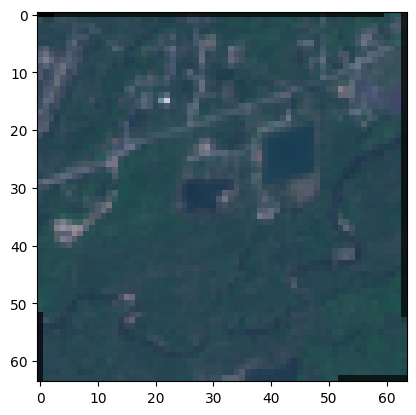

In [71]:
plt.imshow(rgbsS[113][:,:,[3,2,1]])
plt.show()

In [72]:
rgbsS=rgbsS[:,16:-16,16:-16,:]
# rgbsL=rgbsL[:,16:-16,16:-16,:]

In [73]:
# rgbsS.shape,rgbsL.shape

In [74]:
RESIZE_SIZE=rgbsS.shape[1]
RESIZE_SIZE

32

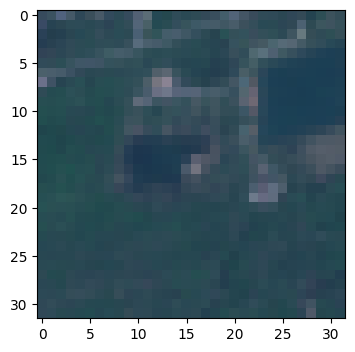

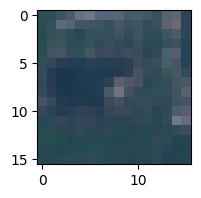

In [77]:
plt.figure(figsize=(4,4))
plt.imshow(rgbsS[113][:,:,[3,2,1]])
plt.show()
plt.figure(figsize=(2,2))
plt.imshow(rgbsS[113][8:-8,8:-8,[3,2,1]])
plt.show()

In [78]:
def select_image(img1, img2, img3=None):
    selection=-1
    if img3 is None:
        medians=np.array([np.median(img1,(0,1)),np.median(img2,(0,1))])
    else:
        medians=np.array([np.median(img1,(0,1)),np.median(img2,(0,1)),np.median(img3,(0,1))])
    medians=np.vstack(medians)    
    median_mins=np.min(medians,1)
#     print(median_mins)
    median_maxes=np.max(medians,1)
#     print(median_maxes)    
    try:
        selection = np.where((median_mins<140)&(median_maxes>40))[0][0]
    except:
        try:
            median_stds=np.std(medians,1)
            if np.max(median_stds)>5:
                selection = np.where(median_stds==np.max(median_stds))[0][0]
        except:
            pass
#         pass
    return selection

In [79]:
# imstatfeatures=np.hstack((np.mean(rgbs,(1,2)),np.median(rgbs,(1,2)),np.std(rgbs,(1,2))))
from scipy.stats import skew
imstatfeaturesS=np.hstack((np.mean(rgbsS,(1,2)),np.median(rgbsS,(1,2)),np.std(rgbsS,(1,2)),
                         skew(rgbsS.reshape(len(rgbsS),RESIZE_SIZE*RESIZE_SIZE,7),1)))
imstatfeaturesS.shape

(23130, 28)

In [80]:
bands=['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
column_names=np.array([x+'_mean' for x in bands]+[x+'_median' for x in bands]+[x+'_std' for x in bands]+[x+'_skew' for x in bands])
column_names

array(['B1_mean', 'B2_mean', 'B3_mean', 'B4_mean', 'B5_mean', 'B6_mean',
       'B7_mean', 'B1_median', 'B2_median', 'B3_median', 'B4_median',
       'B5_median', 'B6_median', 'B7_median', 'B1_std', 'B2_std',
       'B3_std', 'B4_std', 'B5_std', 'B6_std', 'B7_std', 'B1_skew',
       'B2_skew', 'B3_skew', 'B4_skew', 'B5_skew', 'B6_skew', 'B7_skew'],
      dtype='<U9')

In [81]:
imstatfeaturesS=pd.DataFrame(imstatfeaturesS,columns=column_names, index=idsS)

In [82]:
imstatfeaturesS.head()

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,B1_median,B2_median,B3_median,...,B5_std,B6_std,B7_std,B1_skew,B2_skew,B3_skew,B4_skew,B5_skew,B6_skew,B7_skew
bjuh,204.935547,95.929688,116.639648,135.818359,178.242188,195.559570,173.703125,204.0,95.0,115.0,...,21.961969,31.912759,40.971858,0.061251,1.598231,0.455022,0.043085,-0.587238,-0.069780,0.158030
vwkg,214.075195,105.481445,95.421875,82.665039,161.464844,152.497070,109.289062,212.0,102.0,92.0,...,16.063617,26.710141,29.514834,0.675229,0.943646,0.762634,0.667665,0.237760,0.774289,1.362498
fszb,224.544922,82.975586,72.685547,42.861328,162.244141,109.449219,68.365234,222.0,81.0,70.0,...,19.245407,22.467628,24.824765,2.124142,3.628083,2.810614,2.882374,-0.105608,2.171485,2.245795
oncc,167.361328,72.881836,67.140625,41.896484,191.728516,123.849609,80.743164,166.0,71.0,66.0,...,22.308791,33.459001,36.095055,0.504490,1.075924,0.973907,1.617852,-1.744113,0.293521,0.786432
todo,185.748047,70.275391,57.586914,39.721680,34.293945,26.166992,24.258789,183.0,68.0,54.0,...,35.951200,36.927696,34.032963,2.721798,3.679524,3.533994,3.643745,3.687120,3.725532,3.778880


In [83]:
DATA_DIR=''
metadata = pd.read_csv(DATA_DIR + "metadata.csv")
train_labels = pd.read_csv(DATA_DIR + "train_labels.csv")
submission_format = pd.read_csv(DATA_DIR + "submission_format.csv", index_col=0)

metadata.date = pd.to_datetime(metadata.date)
metadata["season"] = (
    metadata.date.dt.month.replace([12, 1, 2], "winter")
    .replace([3, 4, 5], "spring")
    .replace([6, 7, 8], "summer")
    .replace([9, 10, 11], "fall")
)
metadata=metadata.merge(train_labels,on='uid',how='left')
# metadata.loc[:,['severity','density']]=metadata.loc[:,['severity','density']].fillna(-1)


metadata['latlong']=metadata['latitude'].round(2).astype(str)+'_'+metadata['longitude'].round(2).astype(str)
metadata['latlong1']=metadata['latitude'].round(1).astype(str)+'_'+metadata['longitude'].round(1).astype(str)
metadata['latlong0']=metadata['latitude'].round(0).astype(str)+'_'+metadata['longitude'].round(0).astype(str)
metadata['latlong10']=metadata['latitude'].round(1).astype(str)+'_'+metadata['longitude'].round(0).astype(str)
metadata['latlong0div3']=(metadata['latitude']/3).round(0).astype(str)+'_'+(metadata['longitude']/3).round(0).astype(str)
metadata['latlong0div5']=(metadata['latitude']/5).round(0).astype(str)+'_'+(metadata['longitude']/5).round(0).astype(str)
metadata['latlong0div6']=(metadata['latitude']/6).round(0).astype(str)+'_'+(metadata['longitude']/6).round(0).astype(str)
metadata['latlong0div10']=(metadata['latitude']/10).round(0).astype(str)+'_'+(metadata['longitude']/10).round(0).astype(str)
unique_points=np.unique(metadata.latlong)
unique_points1=np.unique(metadata.latlong1)
unique_points0=np.unique(metadata.latlong0)
unique_points10=np.unique(metadata.latlong10)

metadata=metadata.merge(altDF,how='left')#.fillna(-1)
metadata.loc[:,['DEMmean','DEMmedian','DEMstd']]=metadata.loc[:,['DEMmean','DEMmedian','DEMstd']].fillna(-1)
metadata.loc[:,['altitude']]=metadata.loc[:,['altitude']].fillna(-1)

# metadata=metadata.sort_values('date')                    

In [84]:
metadata['lattimeslong']=metadata['latitude']*metadata['longitude']

In [85]:
metadata.loc[:,['longitude','latitude','lattimeslong']].describe()

,longitude,latitude,lattimeslong
count,23570.000000,23570.000000,23570.000000
mean,-91.438307,37.599112,-3439.336874
std,17.886877,2.823860,720.282224
min,-124.179200,26.389430,-5963.833274
25%,-109.370945,35.700925,-4190.029175
50%,-79.268000,36.228150,-3073.003492
75%,-79.026108,38.930270,-2826.734541
max,-67.698650,48.973250,-2114.187601


In [86]:
# Add kmeans features to possible use in cross validation split

from sklearn.cluster import KMeans
X=metadata.loc[metadata.split=='train',['latitude','longitude']].values
kmeans = KMeans(n_clusters=40, random_state=0,).fit(X)
# train_preds=kmeans.predict(X)
metadata['Kmeans40']=kmeans.predict(metadata.loc[:,['latitude','longitude']].values)

kmeans = KMeans(n_clusters=200, random_state=0,).fit(X)
metadata['Kmeans200']=kmeans.predict(metadata.loc[:,['latitude','longitude']].values)

kmeans = KMeans(n_clusters=80, random_state=0,).fit(X)
metadata['Kmeans80']=kmeans.predict(metadata.loc[:,['latitude','longitude']].values)

kmeans = KMeans(n_clusters=20, random_state=0,).fit(X)
metadata['Kmeans20']=kmeans.predict(metadata.loc[:,['latitude','longitude']].values)

kmeans = KMeans(n_clusters=25, random_state=0,).fit(X)
metadata['Kmeans25']=kmeans.predict(metadata.loc[:,['latitude','longitude']].values)

# kmeans = KMeans(n_clusters=21, random_state=0,).fit(X)
# metadata['Kmeans21']=kmeans.predict(metadata.loc[:,['latitude','longitude']].values)

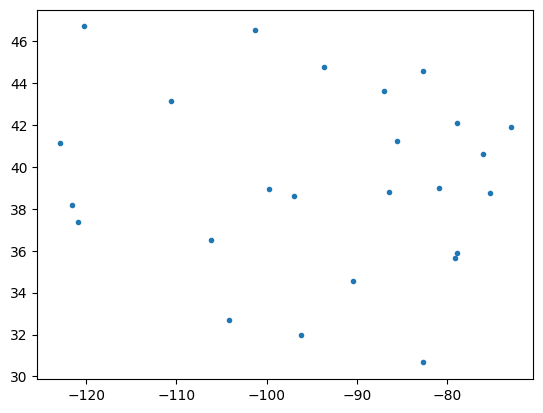

In [87]:
plt.plot(kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,0],'.')
plt.show()

In [88]:
# metadata.loc[metadata.split=='train',['Kmeans80','severity']].groupby('Kmeans80').mean()
df=metadata.loc[:,['Kmeans40','split','uid','severity']].groupby(['split','Kmeans40']).count()#.loc[( 'test',  77)]
# for ind in df.index:
#     print(ind,df.loc[ind]['uid'])

In [91]:
# df['uid'].to_dict()
dftrain=metadata.loc[metadata.split=='train',['Kmeans40','uid','severity']].groupby('Kmeans40').count()[['uid']]
dftest=metadata.loc[metadata.split=='test',['Kmeans40','uid','severity']].groupby('Kmeans40').count()[['uid']]
dftest.columns=['uid_test']
dftrain.columns=['uid_train']
dftest.head()

,uid_test
Kmeans40,
0,516
1,560
2,215
3,80
4,825


In [92]:
df2=dftrain.merge(dftest,left_index=True,right_index=True)
df2['ratio']=df2.uid_train/df2.uid_test
df2.head()

,uid_train,uid_test,ratio
Kmeans40,,,
0,190,516,0.368217
1,5166,560,9.225000
2,455,215,2.116279
3,267,80,3.337500
4,461,825,0.558788


In [93]:
remove_clusters40_fromtrain=[x for x in range(40) if x not in df2.index]
remove_clusters40_fromtrain

[12, 38, 39]

In [94]:
remove_uids=metadata.uid.loc[metadata.Kmeans40.isin(remove_clusters40_fromtrain)].values
len(remove_uids)

194

In [95]:
# also from cluster 1 remove 3000 samples
cluster1uids=metadata.loc[(metadata.split=='train')&(metadata.Kmeans40==1),'uid'].values
len(cluster1uids)

5166

In [96]:
np.random.seed(42)
remove_uids=np.concatenate((remove_uids, np.random.choice(cluster1uids,3000)))

In [97]:
len(remove_uids)

3194

In [98]:
metadata.shape
# metadata=metadata.loc[~metadata.uid.isin(remove_uids),:].reset_index(drop=True)
metadata['use_for_train']=1
metadata.loc[metadata.uid.isin(remove_uids),'use_for_train']=0
metadata.shape

(23570, 28)

In [99]:
metadata.groupby('split')['uid'].count()
# test      6510
# train    17060

split
test      6510
train    17060
Name: uid, dtype: int64

In [100]:
# plt.hist(train_preds)
# plt.show()
metadata.altitude.unique().shape

(857,)

In [101]:
metadata.loc[metadata.split=='train',['latitude','longitude']].describe()


,latitude,longitude
count,17060.000000,17060.000000
mean,37.307321,-89.744762
std,2.383112,17.194386
min,26.389430,-124.179200
25%,35.705383,-97.101940
50%,35.980000,-79.203063
75%,38.160200,-79.011995
max,48.907060,-68.065070


In [102]:
len(np.unique(metadata['latlong0'])),len(np.unique(metadata['latlong10'])),len(np.unique(metadata['latlong1']))

(542, 1285, 1795)

In [103]:
# len(np.unique((metadata['latitude']6).round(0).astype(str)+'_'+(metadata['longitude']/6).round(1).astype(str)))
len(np.unique(metadata['latlong0div3'])),len(np.unique(metadata['latlong0div5'])),len(np.unique(metadata['latlong0div6'])),len(np.unique(metadata['latlong0div10']))


(110, 50, 38, 17)

In [104]:
metadata.head()

,uid,latitude,longitude,date,split,season,region,severity,density,latlong,...,DEMmean,DEMmedian,DEMstd,lattimeslong,Kmeans40,Kmeans200,Kmeans80,Kmeans20,Kmeans25,use_for_train
0,aabm,39.080319,-86.430867,2018-05-14,train,spring,midwest,1.0,585.0,39.08_-86.43,...,61.069930,22.5,68.402346,-3377.745847,14,79,43,16,9,1
1,aabn,36.559700,-121.510000,2016-08-31,test,summer,NaN,NaN,NaN,36.56_-121.51,...,62.063702,40.0,53.451200,-4442.369147,16,176,1,1,1,1
2,aacd,35.875083,-78.878434,2020-11-19,train,fall,south,1.0,290.0,35.88_-78.88,...,130.127404,133.0,44.633880,-2829.770396,30,168,37,0,0,1
3,aaee,35.487000,-79.062133,2016-08-24,train,summer,south,1.0,1614.0,35.49_-79.06,...,147.151442,152.0,50.721441,-2805.677912,1,41,72,0,19,1
4,aaff,38.049471,-99.827001,2019-07-23,train,summer,midwest,3.0,111825.0,38.05_-99.83,...,132.240093,131.5,52.735658,-3798.364566,39,32,70,18,21,0


In [105]:
seasondist={'spring':0, 'summer':1, 'fall':2, 'winter':3}
metadata['season_num']=metadata.season.apply(lambda x: seasondist[x])
metadata['month']=metadata.date.dt.month.values
metadata['year']=metadata.date.dt.year.values
metadata['dayofweek']=metadata.date.dt.dayofweek.values

seasondf=metadata.loc[:,['uid','month']]


In [106]:
metadata=metadata.merge(clim_featuresDF,how='left')
metadata.loc[:,['climate_mean', 'climate_median','climate_std']]=metadata.loc[:,['climate_mean', 'climate_median','climate_std']].fillna(-999)
# for month in range(1,13):
#     metadata.loc[metadata.month==month,['climate_mean', 'climate_median','climate_std']]=metadata.loc[metadata.month==month,['climate_mean', 'climate_median','climate_std']].mean().values
metadata.head()

,uid,latitude,longitude,date,split,season,region,severity,density,latlong,...,Kmeans20,Kmeans25,use_for_train,season_num,month,year,dayofweek,climate_mean,climate_median,climate_std
0,aabm,39.080319,-86.430867,2018-05-14,train,spring,midwest,1.0,585.0,39.08_-86.43,...,16,9,1,0,5,2018,0,14.701429,14.70000,5.290277
1,aabn,36.559700,-121.510000,2016-08-31,test,summer,NaN,NaN,NaN,36.56_-121.51,...,1,1,1,1,8,2016,2,12.985714,12.92000,0.737696
2,aacd,35.875083,-78.878434,2020-11-19,train,fall,south,1.0,290.0,35.88_-78.88,...,0,0,1,2,11,2020,3,11.290000,12.16000,5.688601
3,aaee,35.487000,-79.062133,2016-08-24,train,summer,south,1.0,1614.0,35.49_-79.06,...,0,19,1,1,8,2016,2,28.199286,28.22000,2.272195
4,aaff,38.049471,-99.827001,2019-07-23,train,summer,midwest,3.0,111825.0,38.05_-99.83,...,18,21,0,1,7,2019,1,23.267857,23.71875,2.422623


In [107]:
metadata=metadata.merge(clim_featuresW1DF,how='left')
metadata.loc[:,['climate_mean_fw', 'climate_median_fw','climate_std_fw']]=metadata.loc[:,['climate_mean_fw', 'climate_median_fw','climate_std_fw']].fillna(-999)
# for month in range(1,13):
#     metadata.loc[metadata.month==month,['climate_mean', 'climate_median','climate_std']]=metadata.loc[metadata.month==month,['climate_mean', 'climate_median','climate_std']].mean().values
metadata.head()

,uid,latitude,longitude,date,split,season,region,severity,density,latlong,...,season_num,month,year,dayofweek,climate_mean,climate_median,climate_std,climate_mean_fw,climate_median_fw,climate_std_fw
0,aabm,39.080319,-86.430867,2018-05-14,train,spring,midwest,1.0,585.0,39.08_-86.43,...,0,5,2018,0,14.701429,14.70000,5.290277,20.600000,20.6400,2.453313
1,aabn,36.559700,-121.510000,2016-08-31,test,summer,NaN,NaN,NaN,36.56_-121.51,...,1,8,2016,2,12.985714,12.92000,0.737696,13.200000,13.1600,0.609262
2,aacd,35.875083,-78.878434,2020-11-19,train,fall,south,1.0,290.0,35.88_-78.88,...,2,11,2020,3,11.290000,12.16000,5.688601,6.542857,7.6400,4.648114
3,aaee,35.487000,-79.062133,2016-08-24,train,summer,south,1.0,1614.0,35.49_-79.06,...,1,8,2016,2,28.199286,28.22000,2.272195,26.677143,26.0600,2.070705
4,aaff,38.049471,-99.827001,2019-07-23,train,summer,midwest,3.0,111825.0,38.05_-99.83,...,1,7,2019,1,23.267857,23.71875,2.422623,24.508929,25.9375,3.700632


In [108]:
np.corrcoef(metadata.loc[metadata.split=='train','climate_mean'],metadata.loc[metadata.split=='train','climate_mean_fw'])

array([[1.        , 0.96842682],
       [0.96842682, 1.        ]])

In [109]:
metadata=metadata.merge(clim_featuresRDF,how='left')
metadata.loc[:,['rain_mean', 'rain_median','rain_std']]=metadata.loc[:,['rain_mean', 'rain_median','rain_std']].fillna(-999)
# for month in range(1,13):
#     metadata.loc[metadata.month==month,['climate_mean', 'climate_median','climate_std']]=metadata.loc[metadata.month==month,['climate_mean', 'climate_median','climate_std']].mean().values
metadata.head()

,uid,latitude,longitude,date,split,season,region,severity,density,latlong,...,dayofweek,climate_mean,climate_median,climate_std,climate_mean_fw,climate_median_fw,climate_std_fw,rain_mean,rain_median,rain_std
0,aabm,39.080319,-86.430867,2018-05-14,train,spring,midwest,1.0,585.0,39.08_-86.43,...,0,14.701429,14.70000,5.290277,20.600000,20.6400,2.453313,0.115714,0.0,0.283315
1,aabn,36.559700,-121.510000,2016-08-31,test,summer,NaN,NaN,NaN,36.56_-121.51,...,2,12.985714,12.92000,0.737696,13.200000,13.1600,0.609262,0.005714,0.0,0.029692
2,aacd,35.875083,-78.878434,2020-11-19,train,fall,south,1.0,290.0,35.88_-78.88,...,3,11.290000,12.16000,5.688601,6.542857,7.6400,4.648114,0.221429,0.0,0.407428
3,aaee,35.487000,-79.062133,2016-08-24,train,summer,south,1.0,1614.0,35.49_-79.06,...,2,28.199286,28.22000,2.272195,26.677143,26.0600,2.070705,0.102143,0.0,0.213698
4,aaff,38.049471,-99.827001,2019-07-23,train,summer,midwest,3.0,111825.0,38.05_-99.83,...,1,23.267857,23.71875,2.422623,24.508929,25.9375,3.700632,0.004464,0.0,0.023197


In [110]:
metadata=metadata.merge(clim_featuresGDF,how='left')
metadata.loc[:,['gust_mean', 'gust_median','gust_std']]=metadata.loc[:,['gust_mean', 'gust_median','gust_std']].fillna(-999)
# for month in range(1,13):
#     metadata.loc[metadata.month==month,['climate_mean', 'climate_median','climate_std']]=metadata.loc[metadata.month==month,['climate_mean', 'climate_median','climate_std']].mean().values
metadata.head()

,uid,latitude,longitude,date,split,season,region,severity,density,latlong,...,climate_std,climate_mean_fw,climate_median_fw,climate_std_fw,rain_mean,rain_median,rain_std,gust_mean,gust_median,gust_std
0,aabm,39.080319,-86.430867,2018-05-14,train,spring,midwest,1.0,585.0,39.08_-86.43,...,5.290277,20.600000,20.6400,2.453313,0.115714,0.0,0.283315,7.077143,6.96,3.164191
1,aabn,36.559700,-121.510000,2016-08-31,test,summer,NaN,NaN,NaN,36.56_-121.51,...,0.737696,13.200000,13.1600,0.609262,0.005714,0.0,0.029692,4.552857,4.52,1.290008
2,aacd,35.875083,-78.878434,2020-11-19,train,fall,south,1.0,290.0,35.88_-78.88,...,5.688601,6.542857,7.6400,4.648114,0.221429,0.0,0.407428,4.365714,3.58,3.366112
3,aaee,35.487000,-79.062133,2016-08-24,train,summer,south,1.0,1614.0,35.49_-79.06,...,2.272195,26.677143,26.0600,2.070705,0.102143,0.0,0.213698,4.055000,4.06,1.606617
4,aaff,38.049471,-99.827001,2019-07-23,train,summer,midwest,3.0,111825.0,38.05_-99.83,...,2.422623,24.508929,25.9375,3.700632,0.004464,0.0,0.023197,8.558036,9.00,4.327579


In [111]:
metadata=metadata.merge(clim_featuresSDF,how='left')
metadata.loc[:,['snowc_mean', 'snowc_median','snowc_std']]=metadata.loc[:,['snowc_mean', 'snowc_median','snowc_std']].fillna(-999)
# for month in range(1,13):
#     metadata.loc[metadata.month==month,['climate_mean', 'climate_median','climate_std']]=metadata.loc[metadata.month==month,['climate_mean', 'climate_median','climate_std']].mean().values
metadata.head()
metadata=metadata.merge(clim_featuresHDF,how='left')
metadata.loc[:,['hgt_mean', 'hgt_median','hgt_std']]=metadata.loc[:,['hgt_mean', 'hgt_median','hgt_std']].fillna(-999)
# for month in range(1,13):
#     metadata.loc[metadata.month==month,['climate_mean', 'climate_median','climate_std']]=metadata.loc[metadata.month==month,['climate_mean', 'climate_median','climate_std']].mean().values
metadata.head()

,uid,latitude,longitude,date,split,season,region,severity,density,latlong,...,rain_std,gust_mean,gust_median,gust_std,snowc_mean,snowc_median,snowc_std,hgt_mean,hgt_median,hgt_std
0,aabm,39.080319,-86.430867,2018-05-14,train,spring,midwest,1.0,585.0,39.08_-86.43,...,0.283315,7.077143,6.96,3.164191,0.0,0.0,0.0,217.805556,217.805556,2.842171e-14
1,aabn,36.559700,-121.510000,2016-08-31,test,summer,NaN,NaN,NaN,36.56_-121.51,...,0.029692,4.552857,4.52,1.290008,0.0,0.0,0.0,342.443787,342.443787,0.000000e+00
2,aacd,35.875083,-78.878434,2020-11-19,train,fall,south,1.0,290.0,35.88_-78.88,...,0.407428,4.365714,3.58,3.366112,0.0,0.0,0.0,108.029586,108.029586,1.421085e-14
3,aaee,35.487000,-79.062133,2016-08-24,train,summer,south,1.0,1614.0,35.49_-79.06,...,0.213698,4.055000,4.06,1.606617,0.0,0.0,0.0,92.242604,92.242604,0.000000e+00
4,aaff,38.049471,-99.827001,2019-07-23,train,summer,midwest,3.0,111825.0,38.05_-99.83,...,0.023197,8.558036,9.00,4.327579,0.0,0.0,0.0,717.793388,717.793388,0.000000e+00


In [112]:
# image_features['green2red_avg']=image_features['green_average']/image_features['red_average']
# image_features['green2blue_md']=image_features['green_median']/image_features['blue_median']
submission_format.head()

,region,severity
uid,,
aabn,west,1
aair,west,1
aajw,northeast,1
aalr,midwest,1
aalw,west,1


In [113]:
np.random.seed(42)
metadata=metadata.iloc[np.random.permutation(len(metadata)),:]

In [114]:
metadata.latlong0.head()

19278     36.0_-79.0
911      39.0_-108.0
4269      36.0_-79.0
2308      36.0_-79.0
21159     36.0_-79.0
Name: latlong0, dtype: object

In [115]:
from sklearn.model_selection import KFold, GroupKFold
NUM_FOLDS=5
kf = GroupKFold(n_splits=NUM_FOLDS)
# kf = KFold(n_splits=NUM_FOLDS, random_state=42, shuffle=True)
folding=np.zeros(len(train_labels))
# train_labels['fold']=0
# for fold, (train_index, test_index) in enumerate(kf.split(train_labels,train_labels, train_locations)):
for fold, (train_index, test_index) in enumerate(kf.split(train_labels,train_labels, 
#                                  metadata.loc[metadata.uid.isin(train_labels.uid),[ 'latlong0']])):    
#                                  metadata.loc[metadata.uid.isin(train_labels.uid),[ 'Kmeans40']])):    
#                                  metadata.loc[metadata.uid.isin(train_labels.uid),[ 'Kmeans25']])):    
                                 metadata.loc[metadata.uid.isin(train_labels.uid),[ 'Kmeans20']])):    
#                                  metadata.loc[metadata.uid.isin(train_labels.uid),[ 'latlong0div5']])):    
#                                  metadata.loc[metadata.uid.isin(train_labels.uid),[ 'latlong0div3']])):    
#                                  metadata.loc[metadata.uid.isin(train_labels.uid),[ 'latlong0div10']])):    
#                                  metadata.loc[metadata.uid.isin(train_labels.uid),[ 'latlong0div6']])):    
#                                  metadata.loc[metadata.uid.isin(train_labels.uid),[ 'latlong10']])):    
    folding[test_index]=fold
#     train_labels.fold.iloc[test_index]=fold
foldingDF=pd.DataFrame({'fold':folding,'uid':train_labels.uid})
foldingDF.head()


,fold,uid
0,0.0,aabm
1,1.0,aacd
2,0.0,aaee
3,0.0,aaff
4,0.0,aafl


In [116]:
metadata=metadata.merge(foldingDF,on='uid',how='left')
metadata['fold']=metadata['fold'].fillna(-1)


In [117]:
for fold in range(NUM_FOLDS):
    print(fold,metadata.loc[metadata.fold==fold,['fold','region']].groupby('region').count())

0            fold
region         
midwest    1287
northeast   617
south      5573
west       2102
1            fold
region         
midwest     229
northeast   142
south      1071
west        445
2            fold
region         
midwest     205
northeast   126
south      1133
west        395
3            fold
region         
midwest     235
northeast   133
south      1084
west        418
4            fold
region         
midwest     244
northeast   125
south      1087
west        409


In [118]:
metadata.month.loc[metadata.year==metadata.year.min()].unique()

array([ 7,  8,  6,  5,  3, 10,  2, 12,  4,  9,  1, 11])

In [119]:
# CREATE target endoded kmeans features - wont be used 

K80=[]
K200=[]
metadata['Kmeans80_mean_severity']=0
metadata['Kmeans200_mean_severity']=0
for fold in range(NUM_FOLDS):
    Kmeans200Severity=metadata.loc[metadata.fold!=fold,:].groupby('Kmeans200',as_index=False)['severity'].mean()
    Kmeans200Severity.columns=['Kmeans200', 'Kmeans200_mean_severity']
    Kmeans200Severity['fold']=fold
    Kmeans200Counts=metadata.loc[metadata.fold!=fold,:].groupby('Kmeans200',as_index=False)['severity'].count()
    Kmeans200Counts.columns=['Kmeans200', 'Kmeans200_counts']
    Kmeans200Severity.loc[Kmeans200Severity.Kmeans200.isin(Kmeans200Counts.loc[Kmeans200Counts.Kmeans200_counts<3,'Kmeans200'].values),'Kmeans200_mean_severity']=np.nan
#     print(Kmeans200Severity.Kmeans200_mean_severity.mean())
    Kmeans200Severity.Kmeans200_mean_severity.fillna(Kmeans200Severity.Kmeans200_mean_severity.mean(),inplace=True)
    K200.append(Kmeans200Severity)

    Kmeans80Severity=metadata.loc[metadata.fold!=fold,:].groupby('Kmeans80',as_index=False)['severity'].mean()
    Kmeans80Severity.columns=['Kmeans80', 'Kmeans80_mean_severity']
    Kmeans80Severity['fold']=fold
    Kmeans80Counts=metadata.loc[metadata.fold!=fold,:].groupby('Kmeans80',as_index=False)['severity'].count()

    Kmeans80Counts.columns=['Kmeans80', 'Kmeans80_counts']
    Kmeans80Severity.loc[Kmeans80Severity.Kmeans80.isin(Kmeans80Counts.loc[Kmeans80Counts.Kmeans80_counts<7,'Kmeans80'].values),'Kmeans80_mean_severity']=np.nan
    Kmeans80Severity.Kmeans80_mean_severity.fillna(Kmeans80Severity.Kmeans80_mean_severity.mean(),inplace=True)
    K80.append(Kmeans80Severity)
    
    for k in K80[fold].Kmeans80.unique():
        metadata['Kmeans80_mean_severity'].loc[(metadata.fold==fold)&(metadata.Kmeans80==k)]=K80[fold].Kmeans80_mean_severity.loc[K80[fold].Kmeans80==k].values[0]
        metadata['Kmeans80_mean_severity'].loc[(metadata.fold==-1)&(metadata.Kmeans80==k)]+=K80[fold].Kmeans80_mean_severity.loc[K80[fold].Kmeans80==k].values[0]/NUM_FOLDS        
    for k in K200[fold].Kmeans200.unique():
        metadata['Kmeans200_mean_severity'].loc[(metadata.fold==fold)&(metadata.Kmeans200==k)]=K200[fold].Kmeans200_mean_severity.loc[K200[fold].Kmeans200==k].values[0]
        metadata['Kmeans200_mean_severity'].loc[(metadata.fold==-1)&(metadata.Kmeans200==k)]+=K200[fold].Kmeans200_mean_severity.loc[K200[fold].Kmeans200==k].values[0]/NUM_FOLDS      
        
metadata['Kmeans200_mean_severity'].loc[metadata['Kmeans200_mean_severity']<1]=metadata['Kmeans200_mean_severity'].loc[metadata['Kmeans200_mean_severity']>=1].mean()
metadata['Kmeans80_mean_severity'].loc[metadata['Kmeans80_mean_severity']<1]=metadata['Kmeans80_mean_severity'].loc[metadata['Kmeans80_mean_severity']>=1].mean()
        
# metadata=metadata.merge(Kmeans200Severity)
# metadata=metadata.merge(Kmeans80Severity)

In [120]:
metadata.fold.unique()

array([ 4.,  0.,  2.,  3., -1.,  1.])

In [122]:
metadata['Kmeans200_mean_severity'].head()

0    1.580271
1    2.387153
2    1.396104
3    1.583770
4    1.553655
Name: Kmeans200_mean_severity, dtype: float64

In [123]:
metadata['split'].loc[metadata['Kmeans80_mean_severity']==-1]

Series([], Name: split, dtype: object)

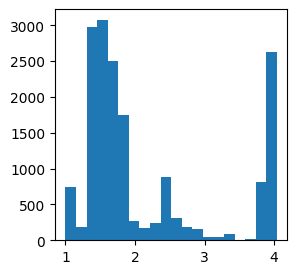

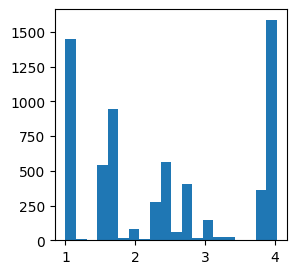

In [130]:
plt.figure(figsize=(3,3))
plt.hist(metadata['Kmeans200_mean_severity'].loc[metadata.split=='train'],20)
plt.show()
plt.figure(figsize=(3,3))
plt.hist(metadata['Kmeans200_mean_severity'].loc[metadata.split=='test'],20)
plt.show()

In [126]:
# train_labels.fold.value_counts()
np.unique(folding,return_counts=True)
metadata.loc[metadata.uid.isin(train_labels.uid),[ 'fold']].value_counts()
metadata.loc[:,[ 'fold']].value_counts()

fold
 0.0    9579
-1.0    6510
 1.0    1887
 3.0    1870
 4.0    1865
 2.0    1859
dtype: int64

In [127]:
# create target encoded month and year features - will be used in neural networks - not that important features

metadata['month_mean_severity']=0
metadata['year_mean_severity']=0
for fold in range(NUM_FOLDS):
    MonthSeverity=metadata.loc[metadata.fold!=fold,:].groupby('month',as_index=False)['severity'].mean()
    MonthSeverity.columns=['month', 'Month_mean_severity']
    MonthSeverity['fold']=fold

    YearSeverity=metadata.loc[metadata.fold!=fold,:].groupby('year',as_index=False)['severity'].mean()
    YearSeverity.columns=['year', 'Year_mean_severity']
    YearSeverity['fold']=fold

    for k in MonthSeverity.month.unique():
        metadata['month_mean_severity'].loc[(metadata.fold==fold)&(metadata.month==k)]=MonthSeverity.Month_mean_severity.loc[MonthSeverity.month==k].values[0]
        metadata['month_mean_severity'].loc[(metadata.fold==-1)&(metadata.month==k)]+=MonthSeverity.Month_mean_severity.loc[MonthSeverity.month==k].values[0]/NUM_FOLDS        
    for k in YearSeverity.year.unique():
        metadata['year_mean_severity'].loc[(metadata.fold==fold)&(metadata.year==k)]=YearSeverity.Year_mean_severity.loc[YearSeverity.year==k].values[0]
        metadata['year_mean_severity'].loc[(metadata.fold==-1)&(metadata.year==k)]+=YearSeverity.Year_mean_severity.loc[YearSeverity.year==k].values[0]/NUM_FOLDS        
        
metadata['month_mean_severity'].loc[metadata['month_mean_severity']<1]=metadata['month_mean_severity'].loc[metadata['month_mean_severity']>=1].mean()
metadata['year_mean_severity'].loc[metadata['year_mean_severity']<1]=metadata['year_mean_severity'].loc[metadata['year_mean_severity']>=1].mean()



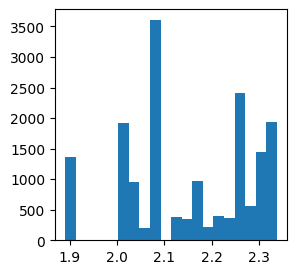

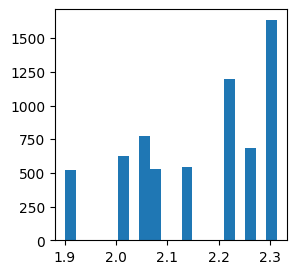

In [129]:
plt.figure(figsize=(3,3))
plt.hist(metadata['year_mean_severity'].loc[metadata.split=='train'],20)
plt.show()
plt.figure(figsize=(3,3))
plt.hist(metadata['year_mean_severity'].loc[metadata.split=='test'],20)
plt.show()

In [131]:
k

2021

In [132]:
metadata['density_sqr']=metadata['density']**0.5

In [133]:

imstatfeaturesStrain = metadata.loc[metadata.split=='train',:].merge(
    imstatfeaturesS, how="left", left_on="uid", right_index=True#, validate="1:1"
)

meancols=[x for x in imstatfeaturesS if 'mean' in x]+[x for x in imstatfeaturesS if 'std' in x]+[x for x in imstatfeaturesS if 'skew' in x]
mediancols=[x for x in imstatfeaturesS if 'median' in x]

# fill in missing values
all_col_means=[]
all_col_medians=[]
for avg_col in meancols:
    all_col_means.append(imstatfeaturesS[avg_col].mean())
    imstatfeaturesStrain[avg_col] = imstatfeaturesStrain[avg_col].fillna(
        imstatfeaturesS[avg_col].mean() )
    
for median_col in mediancols:
    all_col_medians.append( imstatfeaturesS[median_col].median())
    imstatfeaturesStrain[median_col] = imstatfeaturesStrain[median_col].fillna(
        imstatfeaturesS[median_col].median() )
all_col_means,all_col_medians

submission_format = pd.read_csv( "submission_format.csv", index_col=0)
submission_format=submission_format.merge(metadata.loc[:,['uid','latitude','longitude', 'month', 'year','dayofweek', 
                                                     'altitude', 'DEMmean', 'DEMmedian', 'DEMstd',   
#                                                           'shapeSLC',
                                                          'lattimeslong',
                                                          'Kmeans200_mean_severity', 'Kmeans80_mean_severity',
                                                          'month_mean_severity','year_mean_severity',
#                                                           'LB10mean','LB10Cmean','LB11mean','LB11Cmean',
                                                           'climate_mean', 'climate_median','climate_std',
                                                          'climate_mean_fw', 'climate_median_fw','climate_std_fw',
                                                          'rain_mean', 'rain_median','rain_std',
                                                          'gust_mean', 'gust_median','gust_std',
                                                          'snowc_mean', 'snowc_median','snowc_std',
                                                          'hgt_mean', 'hgt_median','hgt_std',
#                                                           'Sdays', 'Ldays','Shour', 'Lhour'
                                                         ]],how='left',on='uid')
# submission_format=submission_format.merge(metadata,how='left',on='uid')

imstatfeaturesStest = submission_format.merge(
    imstatfeaturesS,  how="left", left_on="uid", right_index=True#, validate="1:1"
)

# fill in missing values
counter=0
for avg_col in meancols:
    imstatfeaturesStest[avg_col] = imstatfeaturesStest[avg_col].fillna(
        all_col_means[counter]
    )
    counter += 1
counter=0
for median_col in mediancols:
    imstatfeaturesStest[median_col] = imstatfeaturesStest[median_col].fillna(
        all_col_medians[counter]
    )
    counter += 1
    

imstatfeaturesStrain['green2red']=imstatfeaturesStrain['B3_mean']/imstatfeaturesStrain['B4_mean']
imstatfeaturesStest['green2red']=imstatfeaturesStest['B3_mean']/imstatfeaturesStest['B4_mean']

imstatfeaturesStrain['green2blue']=imstatfeaturesStrain['B3_mean']/imstatfeaturesStrain['B2_mean']
imstatfeaturesStest['green2blue']=imstatfeaturesStest['B3_mean']/imstatfeaturesStest['B2_mean']

In [134]:
imstatfeaturesStrain['NDVI']=((imstatfeaturesStrain['B5_median']-imstatfeaturesStrain['B2_median'])/
                             (imstatfeaturesStrain['B5_median']+imstatfeaturesStrain['B2_median']))
imstatfeaturesStest['NDVI']=((imstatfeaturesStest['B5_median']-imstatfeaturesStest['B2_median'])/
                             (imstatfeaturesStest['B5_median']+imstatfeaturesStest['B2_median']))

imstatfeaturesStrain['B3B2']=((imstatfeaturesStrain['B3_median']-imstatfeaturesStrain['B2_median'])/
                             (imstatfeaturesStrain['B3_median']+imstatfeaturesStrain['B2_median']))
imstatfeaturesStest['B3B2']=((imstatfeaturesStest['B3_median']-imstatfeaturesStest['B2_median'])/
                             (imstatfeaturesStest['B3_median']+imstatfeaturesStest['B2_median']))


imstatfeaturesStrain['B3B4']=((imstatfeaturesStrain['B3_median']-imstatfeaturesStrain['B2_median'])/
                             (imstatfeaturesStrain['B3_median']+imstatfeaturesStrain['B2_median']))
imstatfeaturesStest['B3B4']=((imstatfeaturesStest['B3_median']-imstatfeaturesStest['B4_median'])/
                             (imstatfeaturesStest['B3_median']+imstatfeaturesStest['B4_median']))

imstatfeaturesStrain['B5B4']=((imstatfeaturesStrain['B5_median']-imstatfeaturesStrain['B4_median'])/
                             (imstatfeaturesStrain['B5_median']+imstatfeaturesStrain['B4_median']))
imstatfeaturesStest['B5B4']=((imstatfeaturesStest['B5_median']-imstatfeaturesStest['B4_median'])/
                             (imstatfeaturesStest['B5_median']+imstatfeaturesStest['B4_median']))



In [135]:
imstatfeaturesStrain.shape


(17060, 90)

In [136]:
colorstats=[x for x in imstatfeaturesStest.columns if x.startswith('B')]
colorstats

['B1_mean',
 'B2_mean',
 'B3_mean',
 'B4_mean',
 'B5_mean',
 'B6_mean',
 'B7_mean',
 'B1_median',
 'B2_median',
 'B3_median',
 'B4_median',
 'B5_median',
 'B6_median',
 'B7_median',
 'B1_std',
 'B2_std',
 'B3_std',
 'B4_std',
 'B5_std',
 'B6_std',
 'B7_std',
 'B1_skew',
 'B2_skew',
 'B3_skew',
 'B4_skew',
 'B5_skew',
 'B6_skew',
 'B7_skew',
 'B3B2',
 'B3B4',
 'B5B4']

In [137]:
metadata.columns

Index(['uid', 'latitude', 'longitude', 'date', 'split', 'season', 'region',
       'severity', 'density', 'latlong', 'latlong1', 'latlong0', 'latlong10',
       'latlong0div3', 'latlong0div5', 'latlong0div6', 'latlong0div10',
       'altitude', 'DEMmean', 'DEMmedian', 'DEMstd', 'lattimeslong',
       'Kmeans40', 'Kmeans200', 'Kmeans80', 'Kmeans20', 'Kmeans25',
       'use_for_train', 'season_num', 'month', 'year', 'dayofweek',
       'climate_mean', 'climate_median', 'climate_std', 'climate_mean_fw',
       'climate_median_fw', 'climate_std_fw', 'rain_mean', 'rain_median',
       'rain_std', 'gust_mean', 'gust_median', 'gust_std', 'snowc_mean',
       'snowc_median', 'snowc_std', 'hgt_mean', 'hgt_median', 'hgt_std',
       'fold', 'Kmeans80_mean_severity', 'Kmeans200_mean_severity',
       'month_mean_severity', 'year_mean_severity', 'density_sqr'],
      dtype='object')

In [138]:
feature_colsALL = [
# feature_colsALLims = [
    "month",
    "year",
    'dayofweek',
    "latitude",
    "longitude",
#     'Kmeans200_mean_severity',
#     'Kmeans80_mean_severity',
#     'lattimeslong',
#     'LB10mean',
# #     'LB10Cmean',
# #     'LB11mean',
#     'LB11Cmean',
     'climate_mean',
#     'climate_median',
    'climate_std',
    'climate_mean_fw', 
#     'climate_median_fw',
    'climate_std_fw',
    'rain_mean',
#     'rain_median',
    'rain_std',
    'gust_mean',
#     'gust_median',
    'gust_std',
    'snowc_mean',
#     'snowc_median',
    'snowc_std',
    'hgt_mean',
#     'hgt_median',
    'hgt_std',
#     'Sdays',
#     'Ldays',
#     'CloudCover',
#     'Shour',
#     'Lhour',
#     'shapeSLC',
    'altitude',
    'DEMmean', 
    'DEMmedian', 
    'DEMstd',
#     'satellite',
#     'NDVI',
#     'NDCI',
#     'B8AB4',
    'B3B2',
    'B3B4',
    'B5B4',
    
#     'green2red',
#     'green2blue',
]

colorstats2=[x for x in colorstats if 'skew' not in x]

feature_colsALLims=feature_colsALL+colorstats#+[x+'b' for x in colorstats]+[x+'c' for x in colorstats]
feature_colsALLims2=feature_colsALL+colorstats2#+[x+'b' for x in colorstats]+[x+'c' for x in colorstats]

feature_colsALLims=[x for x in feature_colsALLims if 'median' not in x]
# feature_colsALLims2=[x for x in feature_colsALLims2 if 'skew' not in x]
len(feature_colsALLims),len(feature_colsALLims2)

(47, 48)

In [139]:
for col in feature_colsALL[:-3]:
# for col in feature_colsALL[:-2]:
    print(col,np.corrcoef(metadata.density_sqr.loc[metadata.split=='train'],metadata.loc[metadata.split=='train',col])[0,1])
#     print(col,np.corrcoef(metadata.density.loc[metadata.split=='train'],metadata.loc[metadata.split=='train',col])[0,1])    

month -0.11912686583728034
year 0.00956783311227353
dayofweek -0.09681851181207074
latitude 0.14074401000159104
longitude -0.7735239566539296
climate_mean -0.03284937435112092
climate_std -0.026497908894454678
climate_mean_fw -0.036529653572730386
climate_std_fw -0.03041433844417898
rain_mean -0.026043820624982342
rain_std -0.026085221711733983
gust_mean -0.02717997626558605
gust_std -0.026398972882755577
snowc_mean -0.027047055356253492
snowc_std -0.02811868545143806
hgt_mean -0.060729799170201285
hgt_std -0.02634122348335622
altitude -0.1272556691321754
DEMmean -0.06224730498570561
DEMmedian -0.060958712252084525
DEMstd -0.14334297536875987


In [140]:
imstatfeaturesStrain.columns

Index(['uid', 'latitude', 'longitude', 'date', 'split', 'season', 'region',
       'severity', 'density', 'latlong', 'latlong1', 'latlong0', 'latlong10',
       'latlong0div3', 'latlong0div5', 'latlong0div6', 'latlong0div10',
       'altitude', 'DEMmean', 'DEMmedian', 'DEMstd', 'lattimeslong',
       'Kmeans40', 'Kmeans200', 'Kmeans80', 'Kmeans20', 'Kmeans25',
       'use_for_train', 'season_num', 'month', 'year', 'dayofweek',
       'climate_mean', 'climate_median', 'climate_std', 'climate_mean_fw',
       'climate_median_fw', 'climate_std_fw', 'rain_mean', 'rain_median',
       'rain_std', 'gust_mean', 'gust_median', 'gust_std', 'snowc_mean',
       'snowc_median', 'snowc_std', 'hgt_mean', 'hgt_median', 'hgt_std',
       'fold', 'Kmeans80_mean_severity', 'Kmeans200_mean_severity',
       'month_mean_severity', 'year_mean_severity', 'density_sqr', 'B1_mean',
       'B2_mean', 'B3_mean', 'B4_mean', 'B5_mean', 'B6_mean', 'B7_mean',
       'B1_median', 'B2_median', 'B3_median', 'B4_media

In [141]:
target_col = "density"
target_col = "density_sqr"

In [142]:
len(metadata.altitude.unique()),len(metadata.DEMmean.unique())

(857, 8281)

In [143]:
metadata.altitude.head()

0     215.0
1    3085.0
2     156.0
3      74.0
4     137.0
Name: altitude, dtype: float64

In [144]:
# train_dataSL.loc[:, feature_cols+['fold']]
metadata.shape

(23570, 56)

In [148]:
# from scipy.stats import ks_2samp
# from scipy.stats import ks_2samp
# for col in feature_colsALLims:
#     print(col, ks_2samp(imstatfeaturesStrain[col],imstatfeaturesStest[col]))

In [149]:
# col='longitude'
# # col='altitude'
# ks_2samp(imstatfeaturesStrain[col],imstatfeaturesStest[col])

In [151]:
# imstatfeaturesStrain

In [152]:
# train_data.replace([np.inf, -np.inf], -999, inplace=True)
# train_data.max()
np.array([20000, 100000, 1000000, 10000000])**0.5

array([ 141.42135624,  316.22776602, 1000.        , 3162.27766017])

In [153]:
from functools import partial
import scipy as sp

class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa score
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 1
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 2
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 3
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 4
            else:
                X_p[i] = 5

        # ll = cohen_kappa_score(y, X_p, weights='quadratic')
        ll = mean_squared_error(y, X_p, squared=False)

        return ll

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
#         initial_coef = [1.5, 2.5, 3.5, 4.5]
        # # initial_coef = [1.26214304, 2.57584782, 3.73238044, 4.93409664]
        # initial_coef = [20000, 100000, 1000000, 10000000]
        initial_coef = (np.array([20000, 100000, 1000000, 10000000])**0.5).tolist()
        # initial_coef = np.log1p(np.array([20000, 100000, 1000000, 10000000]))
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 1
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 2
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 3
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 4
            else:
                X_p[i] = 5
        return X_p

    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [154]:
# mfi=model.feature_importances_
import seaborn as sns
def plotImp(mfi, columns , num = 30, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':mfi,'Feature':columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
# plotImp(mfis, feature_cols)    

In [155]:
from sklearn.ensemble import RandomForestRegressor

train_data=imstatfeaturesStrain.reset_index(drop=True).copy()
feature_cols=feature_colsALLims2
test_data=imstatfeaturesStest.copy()

train_data.fillna(-999,inplace=True)
test_data.fillna(-999,inplace=True)
train_data.replace([np.inf, -np.inf], -999, inplace=True)
test_data.replace([np.inf, -np.inf], -999, inplace=True)

DATA_DIR = 'benchmark/'

oof=np.zeros(len(train_data))
test_preds=np.zeros(len(test_data))
mfis=[]
for fold in range(NUM_FOLDS):
        

    val_set_mask = train_data.fold == fold

#     X_train = train_data.loc[~val_set_mask, feature_cols]
    X_train = train_data.loc[~val_set_mask, :]
    y_train = train_data.loc[~val_set_mask, target_col]

    X_train = X_train.loc[:, feature_cols].values
    
#     y_train = train_data.loc[~val_set_mask, target_col]
    
    X_val = train_data.loc[val_set_mask, feature_cols].values
    y_val = train_data.loc[val_set_mask, target_col]
    
#  class sklearn.ensemble.RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)[source]
    rf = RandomForestRegressor(n_estimators=300, #criterion='gini', 
            max_depth=None, min_samples_split=2, min_samples_leaf=1, 
            min_weight_fraction_leaf=0.0, #max_features='sqrt', 
            max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, 
            oob_score=False, n_jobs=8, random_state=42, verbose=0, 
            warm_start=False, #class_weight=None, 
                               ccp_alpha=0.0, max_samples=None)
    rf.fit(X_train, y_train)    
    
#     # Save model
#     joblib.dump(rf, model_path+model_name+'_fold'+str(fold)+'_col'+str(i))
#     rf=joblib.load(model_path+model_name+'_fold'+str(fold)+'_col'+str(i))
        
    mfis.append(rf.feature_importances_)
#     print(model)

#     # save out model weights
#     joblib.dump(model, str(model_save_path))
#     logger.success(f"Model weights saved to {model_save_path}")

    # generate predictions
    preds = rf.predict(X_val)
    test_preds += rf.predict(test_data.loc[:, feature_cols].values)/NUM_FOLDS
    oof[val_set_mask]=preds
    
    
    # get the validation part of the training data
#     val_set = train_data[train_data.fold == fold][
    val_set = train_data[train_data.fold == fold][
        ["uid", "region", "severity"]
    ].copy()
    
    optR = OptimizedRounder()
    optR.fit( preds, val_set["severity"])
    coefficients = optR.coefficients()
    preds2 = optR.predict( preds, coefficients)

    # val_set["pred"] = np.clip((val_preds).astype(int),1,4)
    val_set["pred"] = np.clip(np.round(preds2).astype(int),1,4)

    region_scores = []
    for region in val_set.region.unique():
        sub = val_set[val_set.region == region]
        region_rmse = mean_squared_error(sub.severity, sub.pred, squared=False)
        print(f"RMSE for {region} (n={len(sub)}): {round(region_rmse, 4)}")
        region_scores.append(region_rmse)

    overall_rmse = np.mean(region_scores)
    print(f"Final score: {overall_rmse}")

    print("all mean",mean_squared_error(y_val, np.clip(np.round(preds2).astype(int),1,4), squared=False))
    print("---------------------------------------------")
#     break
mfis=np.mean(np.stack(mfis),0)

RMSE for west (n=2102): 0.4491
RMSE for south (n=5573): 0.7682
RMSE for midwest (n=1287): 0.8127
RMSE for northeast (n=617): 0.8319
Final score: 0.7154822780612479
all mean 1011.9621364143179
---------------------------------------------
RMSE for northeast (n=142): 0.8093
RMSE for south (n=1071): 0.7441
RMSE for midwest (n=229): 0.7985
RMSE for west (n=445): 0.3418
Final score: 0.6734221577868598
all mean 1049.9476782471013
---------------------------------------------
RMSE for south (n=1133): 0.7627
RMSE for west (n=395): 0.3799
RMSE for northeast (n=126): 0.8262
RMSE for midwest (n=205): 0.8525
Final score: 0.705307542845645
all mean 1164.274611481171
---------------------------------------------
RMSE for south (n=1084): 0.7844
RMSE for west (n=418): 0.4208
RMSE for midwest (n=235): 0.848
RMSE for northeast (n=133): 0.8714
Final score: 0.731158505271098
all mean 1023.9284109717446
---------------------------------------------
RMSE for south (n=1087): 0.7763
RMSE for west (n=409): 0.3

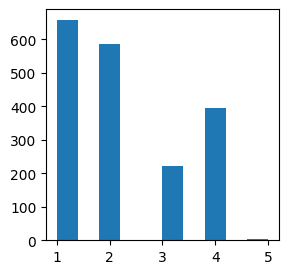

In [156]:
plt.figure(figsize=(3,3))
plt.hist(preds2)
plt.show()

In [157]:
oof4=oof.copy()
test_preds4=test_preds.copy()

In [158]:
def score_oofs(oof, df):
    val_set = df[["uid", "region", "severity"]].copy()
    # val_set["pred"] = np.clip((val_preds).astype(int),1,4)
    optR = OptimizedRounder()
    optR.fit( oof, val_set["severity"])
    coefficients = optR.coefficients()
    # oofb = optR.predict( (oof3+oof4)/2, coefficients)
    oofb = optR.predict( oof, coefficients)

    # val_set["pred"] = np.clip((val_preds).astype(int),1,4)
    val_set["pred"] = np.clip(np.round(oofb).astype(int),1,4)

#     val_set["pred"] = np.clip(np.round(oof).astype(int),1,4)
    # val_set["pred"] = np.clip(np.round((oof+oof2)/2).astype(int),1,4)

    region_scores = []
    for region in val_set.region.unique():
        sub = val_set[val_set.region == region]
        region_rmse = mean_squared_error(sub.severity, sub.pred, squared=False)
        print(f"RMSE for {region} (n={len(sub)}): {round(region_rmse, 4)}")
        region_scores.append(region_rmse)

    overall_rmse = np.mean(region_scores)
    print(f"Final score: {overall_rmse}")

    # print("all mean",mean_squared_error(train_data.loc[:, target_col], np.clip(np.round((oof+oof2)/2).astype(int),1,4), squared=False))
    print("all mean",mean_squared_error(df.loc[:, 'severity'], np.clip(np.round(oofb).astype(int),1,4), squared=False))
    print("---------------------------------------------")
score_oofs(oof4, imstatfeaturesStrain)

RMSE for south (n=9948): 0.7691
RMSE for west (n=3769): 0.4235
RMSE for northeast (n=1143): 0.8176
RMSE for midwest (n=2200): 0.809
Final score: 0.704797120518432
all mean 0.7167400473169485
---------------------------------------------


In [159]:
feature_cols2=np.array(feature_cols)[mfis>0.005]
feature_cols2.shape,len(feature_cols)


((19,), 48)

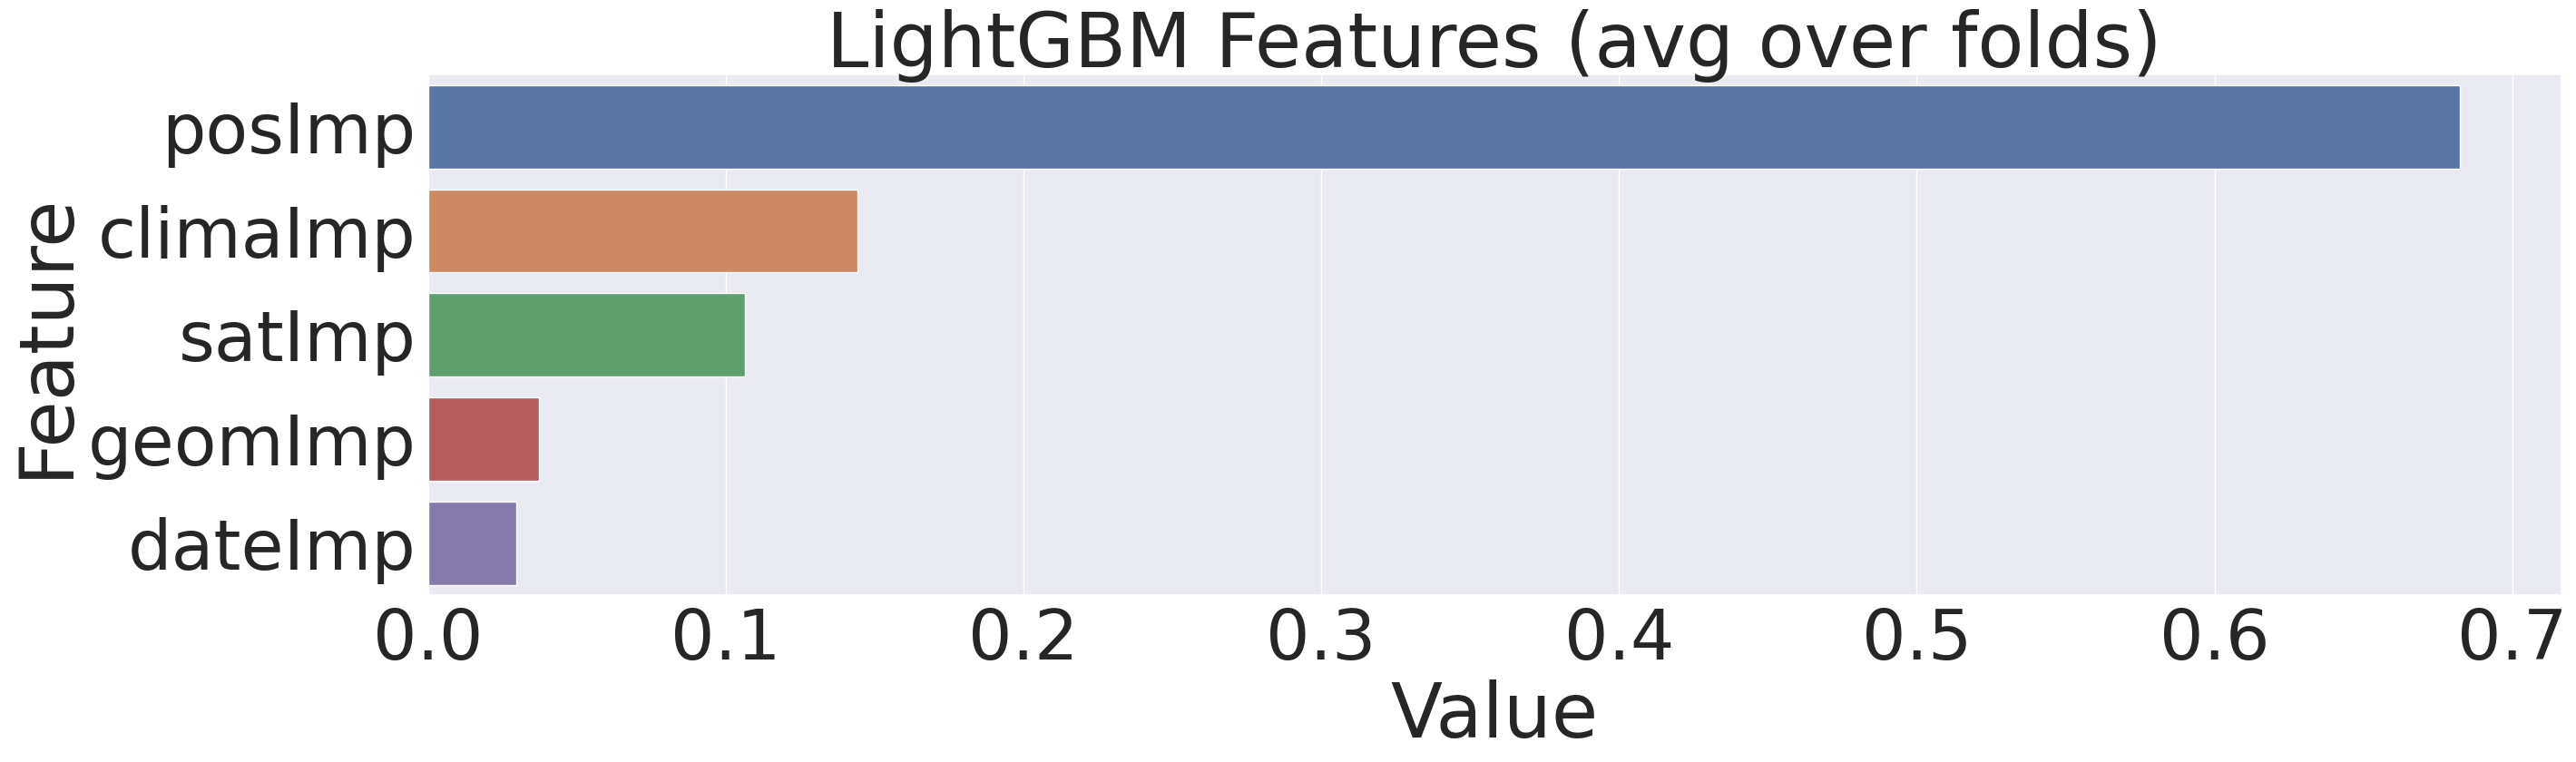

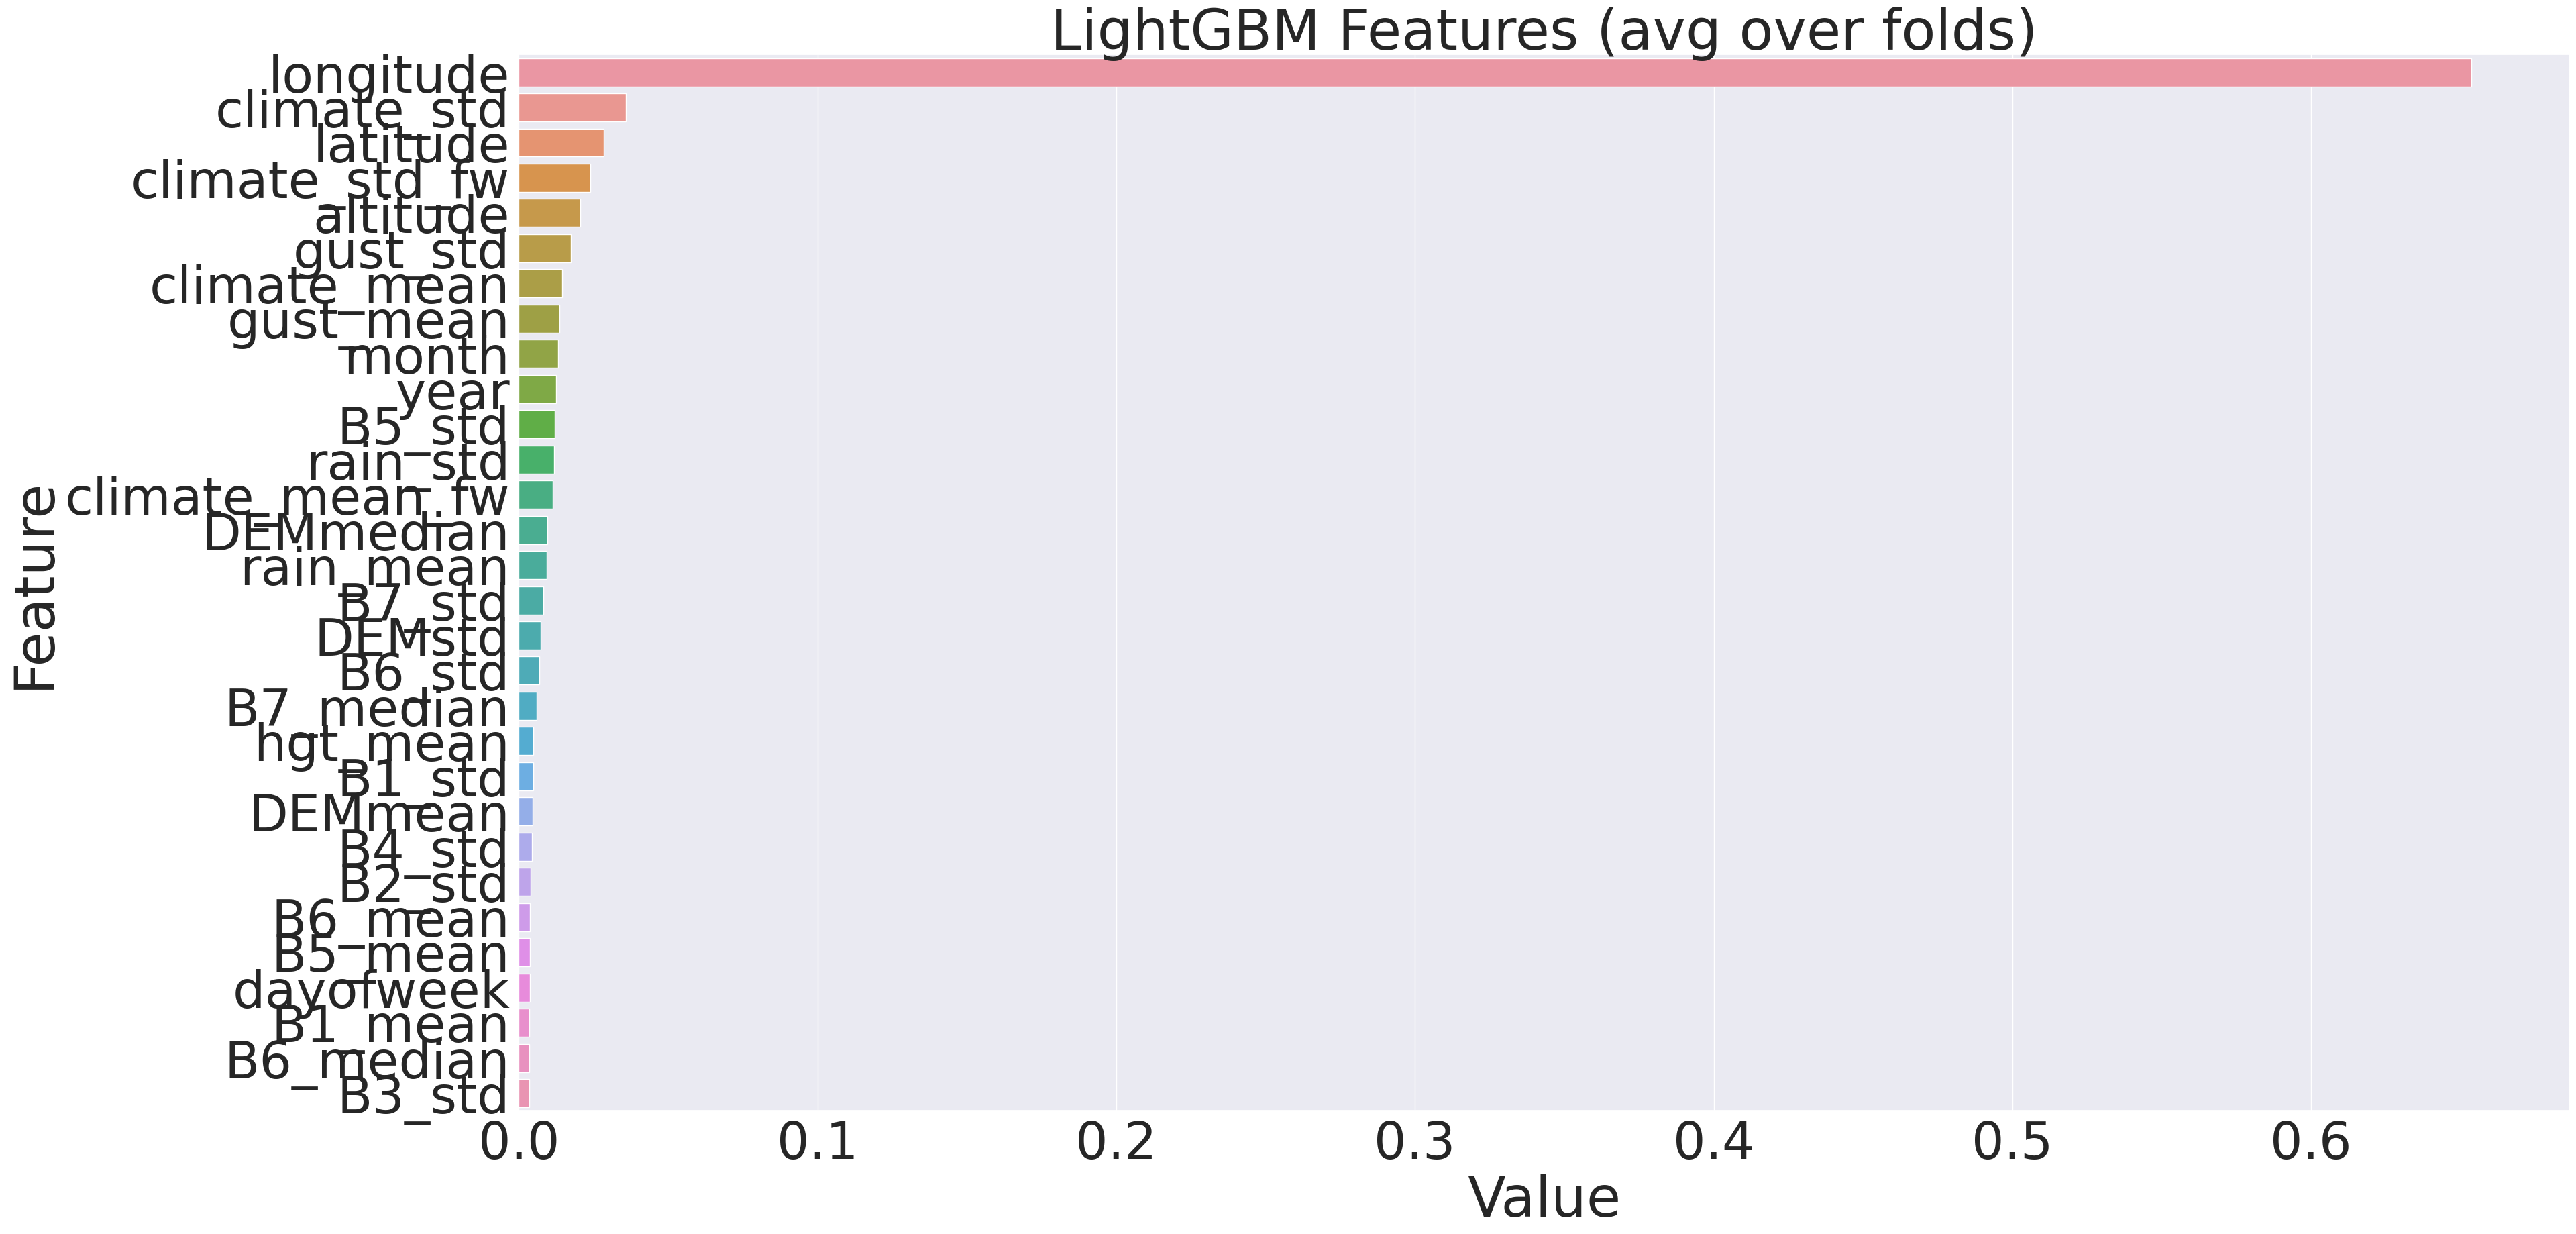

In [160]:
positionF=['latitude', 'longitude','lattimeslong', 'Kmeans200_mean_severity', 'Kmeans80_mean_severity']
positionF=[x for x in positionF if x in feature_cols]
dateF=['month', 'year', 'dayofweek']
dateF=[x for x in dateF if x in feature_cols]
geomF=['altitude', 'if', 'DEMmedian', 'DEMstd']
geomF=[x for x in geomF if x in feature_cols]
climaF=['climate_mean', 'climate_std', 'climate_mean_fw', 'climate_std_fw',
       'rain_mean', 'rain_std', 'gust_mean', 'gust_median', 'gust_std',
       'snowc_mean', 'snowc_median','snowc_std','hgt_mean', 'hgt_median','hgt_std',]
climaF=[x for x in climaF if x in feature_cols]
satelliteF=[x for x in feature_cols if x not in positionF+dateF+geomF+climaF]

posImp=np.sum(mfis[np.array([np.where( np.array(feature_cols)==positionF[x] )[0][0] for x in range(len(positionF))])])
dateImp=np.sum(mfis[np.array([np.where( np.array(feature_cols)==dateF[x] )[0][0] for x in range(len(dateF))])])
geomImp=np.sum(mfis[np.array([np.where( np.array(feature_cols)==geomF[x] )[0][0] for x in range(len(geomF))])])
climaImp=np.sum(mfis[np.array([np.where( np.array(feature_cols)==climaF[x] )[0][0] for x in range(len(climaF))])])
satImp=np.sum(mfis[np.array([np.where( np.array(feature_cols)==satelliteF[x] )[0][0] for x in range(len(satelliteF))])])

plotImp(np.array([posImp,dateImp,geomImp,climaImp,satImp]), ['posImp','dateImp','geomImp','climaImp','satImp'],
        num=10,fig_size = (30, 10))    
plotImp(mfis, feature_cols) 

In [167]:
import lightgbm as lgb

import joblib
import numpy as np
from pathlib import Path


train_data=imstatfeaturesStrain.reset_index(drop=True).copy()
# feature_cols=feature_colsALLims2
feature_cols=feature_cols2
test_data=imstatfeaturesStest.copy()



DATA_DIR = 'benchmark/'
hyper_params = {
    'force_col_wise':True,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.025,
    'feature_fraction': 1,
    'bagging_fraction': 0.9,
    'bagging_freq': 6,
    'subsample':0.8,
    'verbose': -1,
    "max_depth": 6,
#     'min_child_weight':2,
#     'reg_alpha':0.1, 
#     'reg_lambda':0.1,
    "num_leaves": 20,  
    "max_bin": 512,
    "n_jobs":8,
    "n_estimators": 600,
    #"extra_trees":True

}
oof=np.zeros(len(train_data))
test_preds=np.zeros(len(test_data))
# NUM_FOLDS=5
mfis=[]
for fold in range(NUM_FOLDS):
        

    # val_set_mask = train_data.split == "validation"
#     val_set_mask = train_data.fold == fold
    val_set_mask = train_data.fold == fold

#     X_train = train_data.loc[~val_set_mask, feature_cols]
    X_train = train_data.loc[~val_set_mask, :]
    y_train = train_data.loc[~val_set_mask, target_col]
    region_counts=train_data.loc[~val_set_mask, :].groupby('region').count().iloc[:,1].to_dict()
#     y_train = y_train.loc[X_train.use_for_train == True]
#     region_counts=train_data.loc[~val_set_mask, :].loc[X_train.use_for_train == True].groupby('region').count().iloc[:,1].to_dict()
#     print(region_counts)
    region_weights={}
    for region in region_counts:
        region_weights[region]=1+1000/region_counts[region]
#     print(region_weights    )
#     train_sample_weight=train_data.loc[~val_set_mask, 'region'].loc[X_train.use_for_train == True].apply(lambda x: region_weights[x]).values
#     X_train = X_train.loc[X_train.use_for_train == True, feature_cols].values
    train_sample_weight=train_data.loc[~val_set_mask, 'region'].apply(lambda x: region_weights[x]).values
    X_train = X_train.loc[:, feature_cols].values
    
#     y_train = train_data.loc[~val_set_mask, target_col]
    
    X_val = train_data.loc[val_set_mask, feature_cols].values
    y_val = train_data.loc[val_set_mask, target_col]
    

#     region_counts=train_data.loc[~val_set_mask, :].groupby('region').count().iloc[:,1].to_dict()
#     print(region_counts)
#     region_weights={}
#     for region in region_counts:
#         region_weights[region]=1+1000/region_counts[region]
#     print(region_weights    )
#     train_sample_weight=train_data.loc[~val_set_mask, 'region'].apply(lambda x: region_weights[x]).values

    # instantiate tree model
    #model = lgb.LGBMRegressor(random_state=10)
    model = lgb.LGBMRegressor(**hyper_params)
    

    # fit model
#     model.fit(X_train, y_train)
    model.fit(X_train, y_train, sample_weight=train_sample_weight)
    mfis.append(model.feature_importances_)
    print(model)

#     # save out model weights
#     joblib.dump(model, str(model_save_path))
#     logger.success(f"Model weights saved to {model_save_path}")

    # generate predictions
    preds = model.predict(X_val)
    test_preds += model.predict(test_data.loc[:, feature_cols].values)/NUM_FOLDS
    oof[val_set_mask]=preds
    
    
    # get the validation part of the training data
#     val_set = train_data[train_data.fold == fold][
    val_set = train_data[train_data.fold == fold][
        ["uid", "region", "severity"]
    ].copy()
    # val_set["pred"] = np.clip((val_preds).astype(int),1,4)
    optR = OptimizedRounder()
    optR.fit( preds, val_set["severity"])
    coefficients = optR.coefficients()
    preds2 = optR.predict( preds, coefficients)

    # val_set["pred"] = np.clip((val_preds).astype(int),1,4)
    val_set["pred"] = np.clip(np.round(preds2).astype(int),1,4)
#     val_set["pred"] = np.clip(np.round(preds).astype(int),1,4)

    region_scores = []
    for region in val_set.region.unique():
        sub = val_set[val_set.region == region]
        region_rmse = mean_squared_error(sub.severity, sub.pred, squared=False)
        print(f"RMSE for {region} (n={len(sub)}): {round(region_rmse, 4)}")
        region_scores.append(region_rmse)

    overall_rmse = np.mean(region_scores)
    print(f"Final score: {overall_rmse}")

    print("all mean",mean_squared_error(y_val, np.clip(np.round(preds).astype(int),1,4), squared=False))
    print("---------------------------------------------")
mfis=np.mean(np.stack(mfis),0)

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.8 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
LGBMRegressor(bagging_fraction=0.9, bagging_freq=6, feature_fraction=1,
              force_col_wise=True, learning_rate=0.025, max_bin=512,
              max_depth=6, metric=['l1', 'l2'], n_estimators=600, n_jobs=8,
              num_leaves=20, objective='regression', subsample=0.8,
              task='train', verbose=-1)
RMSE for west (n=2102): 0.4395
RMSE for south (n=5573): 0.8052
RMSE for midwest (n=1287): 0.8863
RMSE for northeast (n=617): 0.8802
Final score: 0.75278804593573
all mean 1011.6222581346238
---------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.8 will be ignored. Current value

In [162]:
region_weights

{'midwest': 1.5112474437627812,
 'northeast': 1.9823182711198428,
 'south': 1.1128540796749802,
 'west': 1.2976190476190477}

In [168]:
oof3=oof.copy()
test_preds3=test_preds.copy()

In [179]:
score_oofs(oof3, imstatfeaturesStrain)

RMSE for south (n=9948): 0.8014
RMSE for west (n=3769): 0.4185
RMSE for northeast (n=1143): 0.8659
RMSE for midwest (n=2200): 0.8697
Final score: 0.7388635324277191
all mean 0.7489735062156042
---------------------------------------------


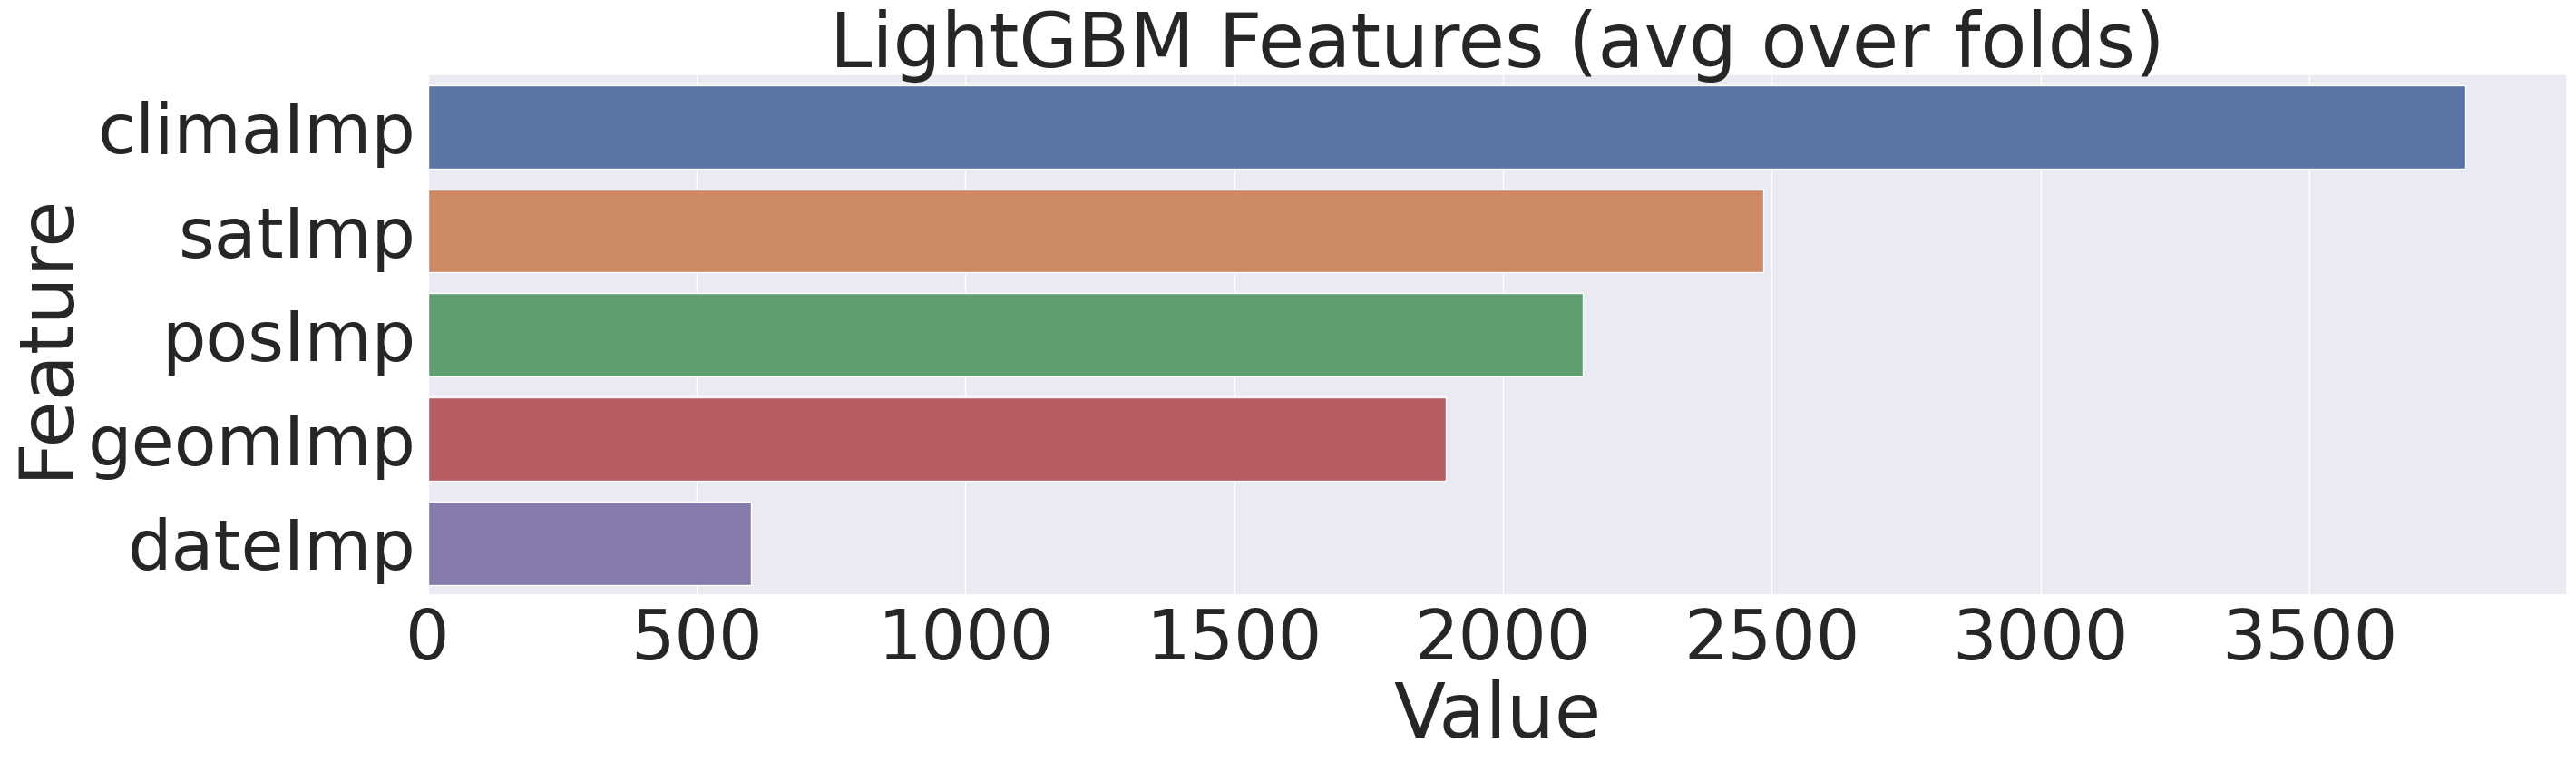

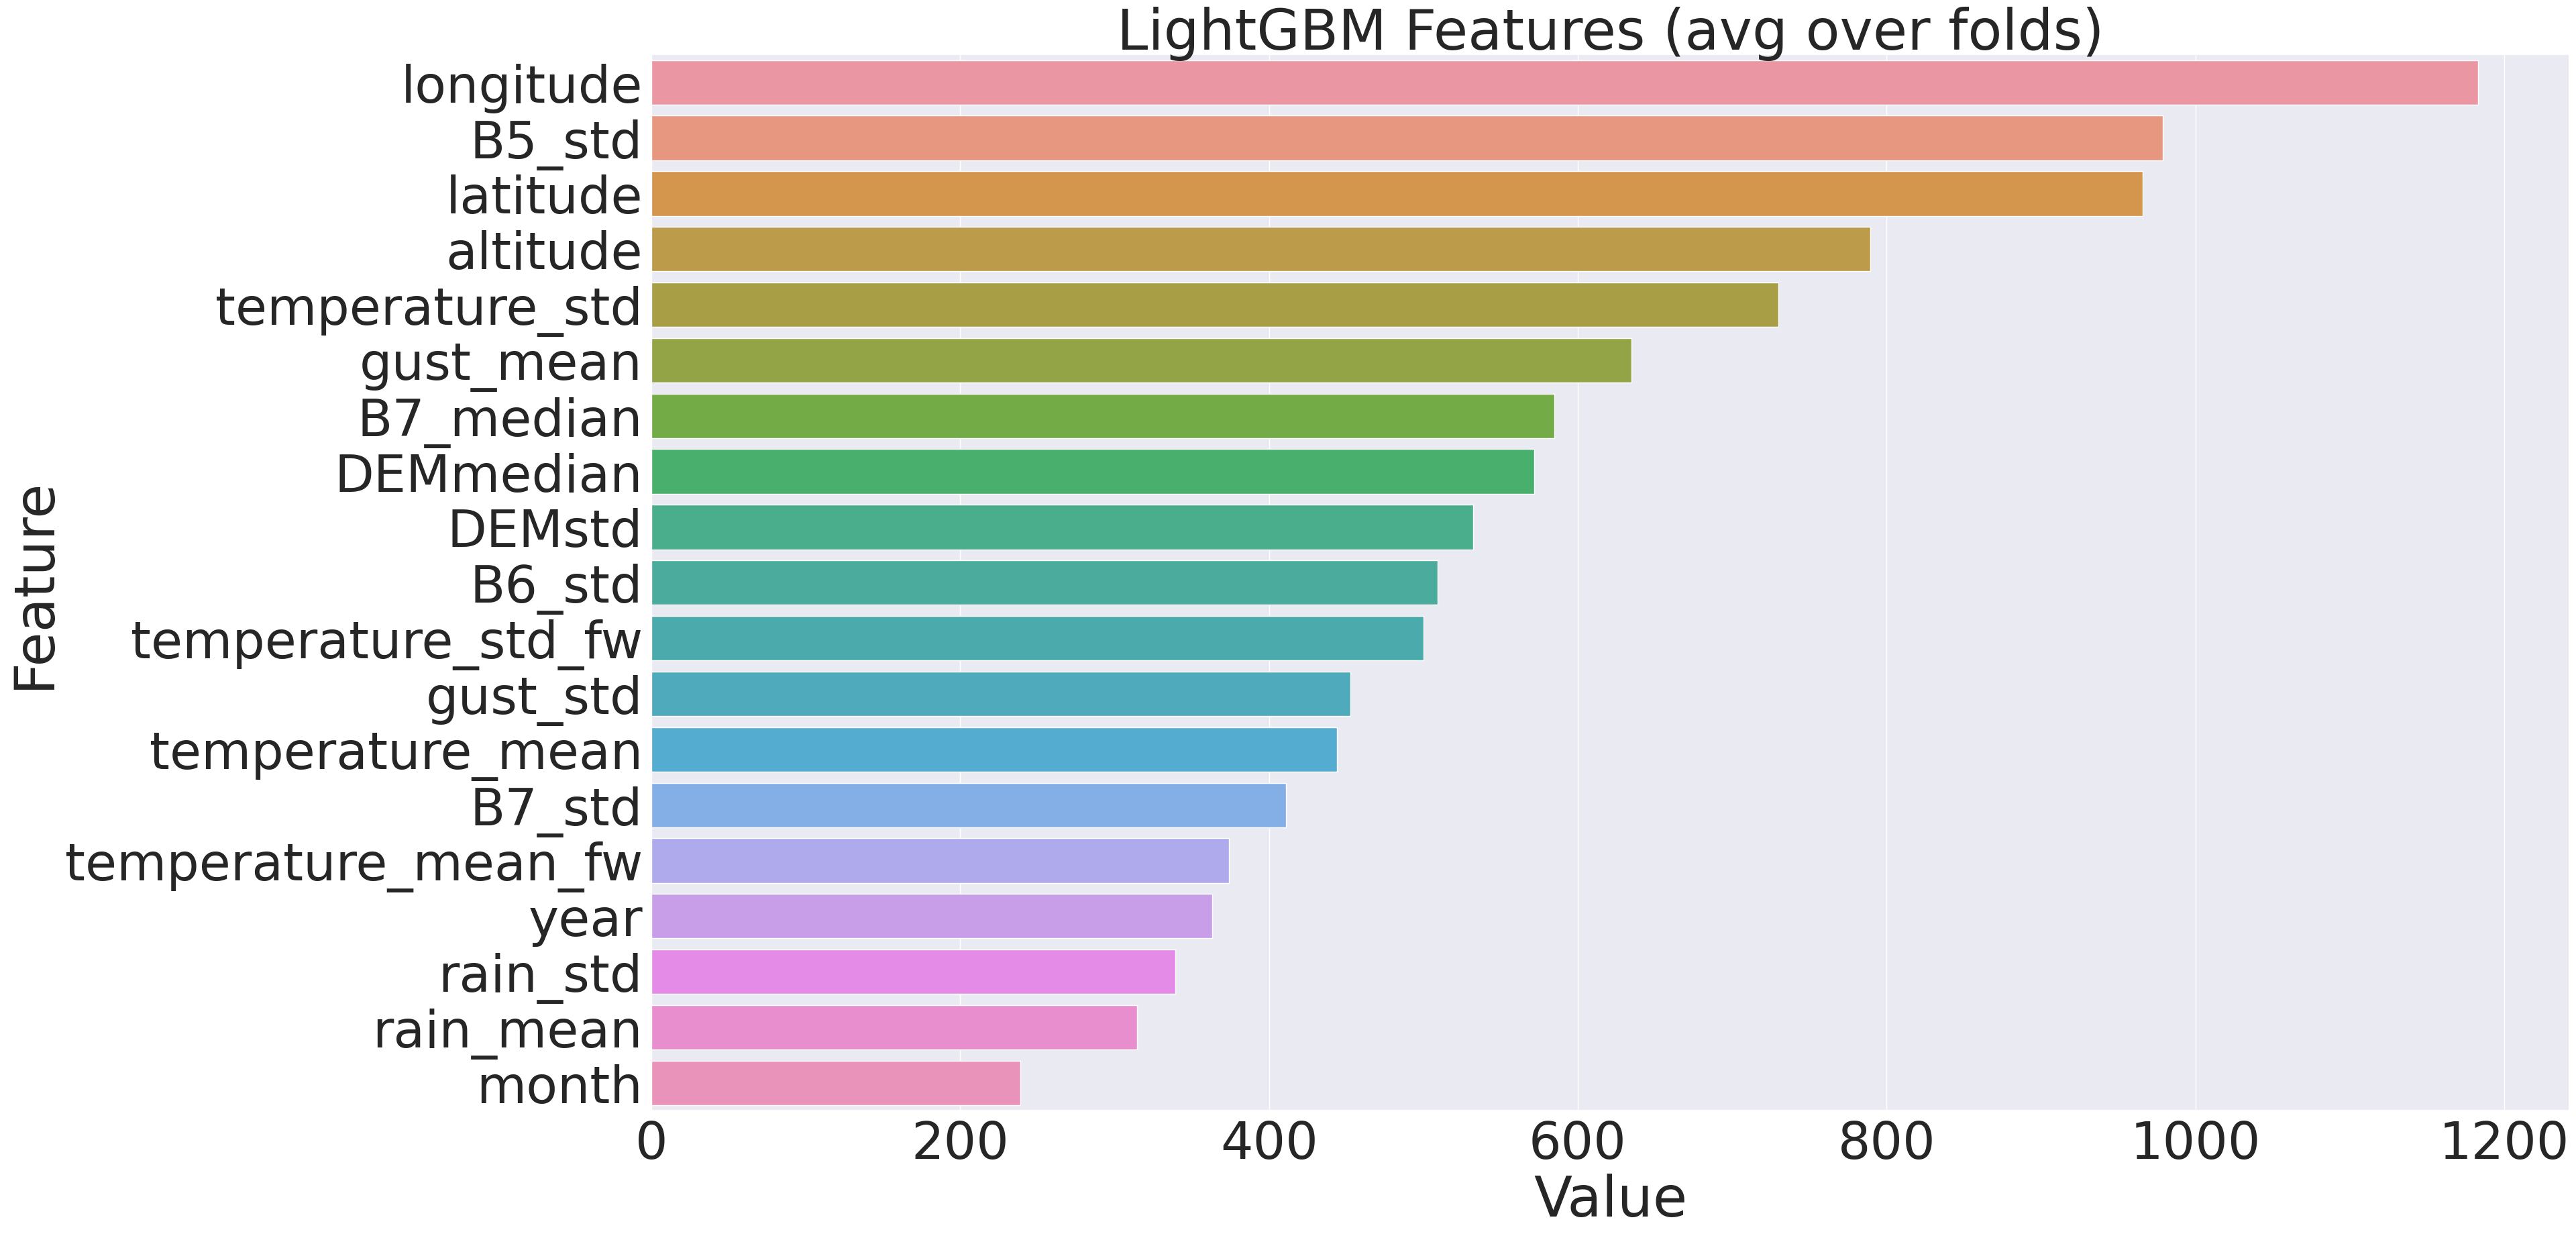

In [172]:
positionF=['latitude', 'longitude','lattimeslong', 'Kmeans200_mean_severity', 'Kmeans80_mean_severity']
positionF=[x for x in positionF if x in feature_cols]
dateF=['month', 'year', 'dayofweek']
dateF=[x for x in dateF if x in feature_cols]
geomF=['altitude', 'if', 'DEMmedian', 'DEMstd']
geomF=[x for x in geomF if x in feature_cols]
climaF=['climate_mean', 'climate_std', 'climate_mean_fw', 'climate_std_fw',
       'rain_mean', 'rain_std', 'gust_mean', 'gust_median', 'gust_std',
       'snowc_mean', 'snowc_median','snowc_std','hgt_mean', 'hgt_median','hgt_std',]
climaF=[x for x in climaF if x in feature_cols]
satelliteF=[x for x in feature_cols if x not in positionF+dateF+geomF+climaF]

posImp=np.sum(mfis[np.array([np.where( np.array(feature_cols)==positionF[x] )[0][0] for x in range(len(positionF))])])
dateImp=np.sum(mfis[np.array([np.where( np.array(feature_cols)==dateF[x] )[0][0] for x in range(len(dateF))])])
geomImp=np.sum(mfis[np.array([np.where( np.array(feature_cols)==geomF[x] )[0][0] for x in range(len(geomF))])])
climaImp=np.sum(mfis[np.array([np.where( np.array(feature_cols)==climaF[x] )[0][0] for x in range(len(climaF))])])
satImp=np.sum(mfis[np.array([np.where( np.array(feature_cols)==satelliteF[x] )[0][0] for x in range(len(satelliteF))])])

plotImp(np.array([posImp,dateImp,geomImp,climaImp,satImp]), ['posImp','dateImp','geomImp','climaImp','satImp'],
        num=10,fig_size = (30, 10))    
# plotImp(mfis, feature_cols)   
plotImp(mfis, [x.replace('climate', 'temperature') for x in feature_cols])   



In [332]:
import lightgbm as lgb

import joblib
import numpy as np
from pathlib import Path

train_data=imstatfeaturesStrain.reset_index(drop=True).copy()
feature_cols=feature_colsALLims2
# feature_cols=feature_cols2
test_data=imstatfeaturesStest.copy()


DATA_DIR = 'benchmark/'
hyper_params = {
    'force_col_wise':True,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.025,
    'feature_fraction': 1,
    'bagging_fraction': 0.9,
    'bagging_freq': 6,
    'subsample':0.8,
    'verbose': -1,
    "max_depth": 6,
#     'min_child_weight':2,
#     'reg_alpha':0.1, 
#     'reg_lambda':0.1,
    "num_leaves": 20,  
    "max_bin": 512,
    "n_jobs":8,
    "n_estimators": 600,
    #"extra_trees":True

}
oof=np.zeros(len(train_data))
test_preds=np.zeros(len(test_data))
# NUM_FOLDS=5
mfis=[]
for fold in range(NUM_FOLDS):
        


    val_set_mask = train_data.fold == fold


    X_train = train_data.loc[~val_set_mask, :]
    y_train = train_data.loc[~val_set_mask, target_col]
    region_counts=train_data.loc[~val_set_mask, :].groupby('region').count().iloc[:,1].to_dict()

    region_weights={}
    for region in region_counts:
        region_weights[region]=1+1000/region_counts[region]

    train_sample_weight=train_data.loc[~val_set_mask, 'region'].apply(lambda x: region_weights[x]).values
    X_train = X_train.loc[:, feature_cols].values
    
    
    X_val = train_data.loc[val_set_mask, feature_cols].values
    y_val = train_data.loc[val_set_mask, target_col]

    # instantiate tree model
    #model = lgb.LGBMRegressor(random_state=10)
    model = lgb.LGBMRegressor(**hyper_params)
    

    # fit model
#     model.fit(X_train, y_train)
    model.fit(X_train, y_train, sample_weight=train_sample_weight)
    mfis.append(model.feature_importances_)
    print(model)

#     # save out model weights
#     joblib.dump(model, str(model_save_path))
#     logger.success(f"Model weights saved to {model_save_path}")

    # generate predictions
    preds = model.predict(X_val)
    test_preds += model.predict(test_data.loc[:, feature_cols].values)/NUM_FOLDS
    oof[val_set_mask]=preds
    
    
    # get the validation part of the training data
#     val_set = train_data[train_data.fold == fold][
    val_set = train_data[train_data.fold == fold][
        ["uid", "region", "severity"]
    ].copy()
    # val_set["pred"] = np.clip((val_preds).astype(int),1,4)
    optR = OptimizedRounder()
    optR.fit( preds, val_set["severity"])
    coefficients = optR.coefficients()
    preds2 = optR.predict( preds, coefficients)

    # val_set["pred"] = np.clip((val_preds).astype(int),1,4)
    val_set["pred"] = np.clip(np.round(preds2).astype(int),1,4)
#     val_set["pred"] = np.clip(np.round(preds).astype(int),1,4)

    region_scores = []
    for region in val_set.region.unique():
        sub = val_set[val_set.region == region]
        region_rmse = mean_squared_error(sub.severity, sub.pred, squared=False)
        print(f"RMSE for {region} (n={len(sub)}): {round(region_rmse, 4)}")
        region_scores.append(region_rmse)

    overall_rmse = np.mean(region_scores)
    print(f"Final score: {overall_rmse}")

    print("all mean",mean_squared_error(y_val, np.clip(np.round(preds).astype(int),1,4), squared=False))
    print("---------------------------------------------")
mfis=np.mean(np.stack(mfis),0)

In [174]:
positionF=['latitude', 'longitude','lattimeslong', 'Kmeans200_mean_severity', 'Kmeans80_mean_severity']
positionF=[x for x in positionF if x in feature_cols]
dateF=['month', 'year', 'dayofweek']
dateF=[x for x in dateF if x in feature_cols]
geomF=['altitude', 'if', 'DEMmedian', 'DEMstd']
geomF=[x for x in geomF if x in feature_cols]
climaF=['climate_mean', 'climate_std', 'climate_mean_fw', 'climate_std_fw',
       'rain_mean', 'rain_std', 'gust_mean', 'gust_median', 'gust_std',
       'snowc_mean', 'snowc_median','snowc_std','hgt_mean', 'hgt_median','hgt_std',]
climaF=[x for x in climaF if x in feature_cols]
satelliteF=[x for x in feature_cols if x not in positionF+dateF+geomF+climaF]

posImp=np.sum(mfis[np.array([np.where( np.array(feature_cols)==positionF[x] )[0][0] for x in range(len(positionF))])])
dateImp=np.sum(mfis[np.array([np.where( np.array(feature_cols)==dateF[x] )[0][0] for x in range(len(dateF))])])
geomImp=np.sum(mfis[np.array([np.where( np.array(feature_cols)==geomF[x] )[0][0] for x in range(len(geomF))])])
climaImp=np.sum(mfis[np.array([np.where( np.array(feature_cols)==climaF[x] )[0][0] for x in range(len(climaF))])])
satImp=np.sum(mfis[np.array([np.where( np.array(feature_cols)==satelliteF[x] )[0][0] for x in range(len(satelliteF))])])


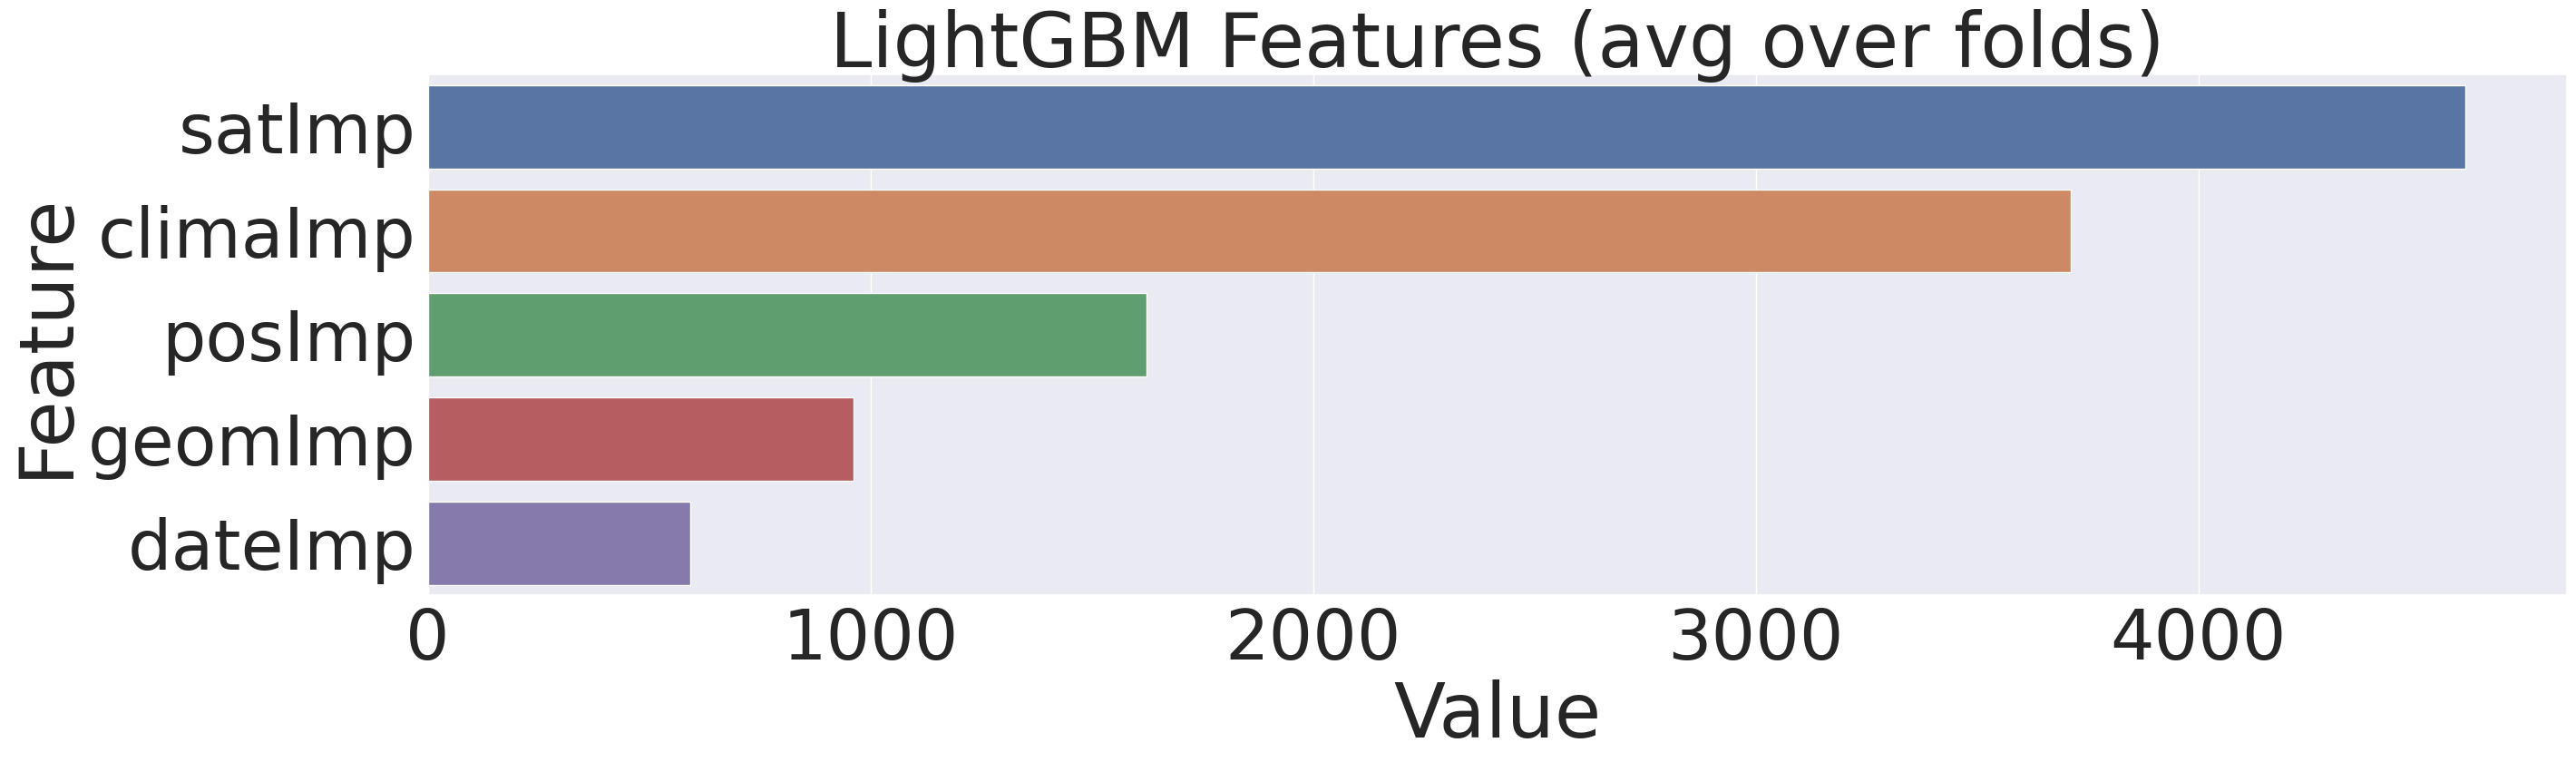

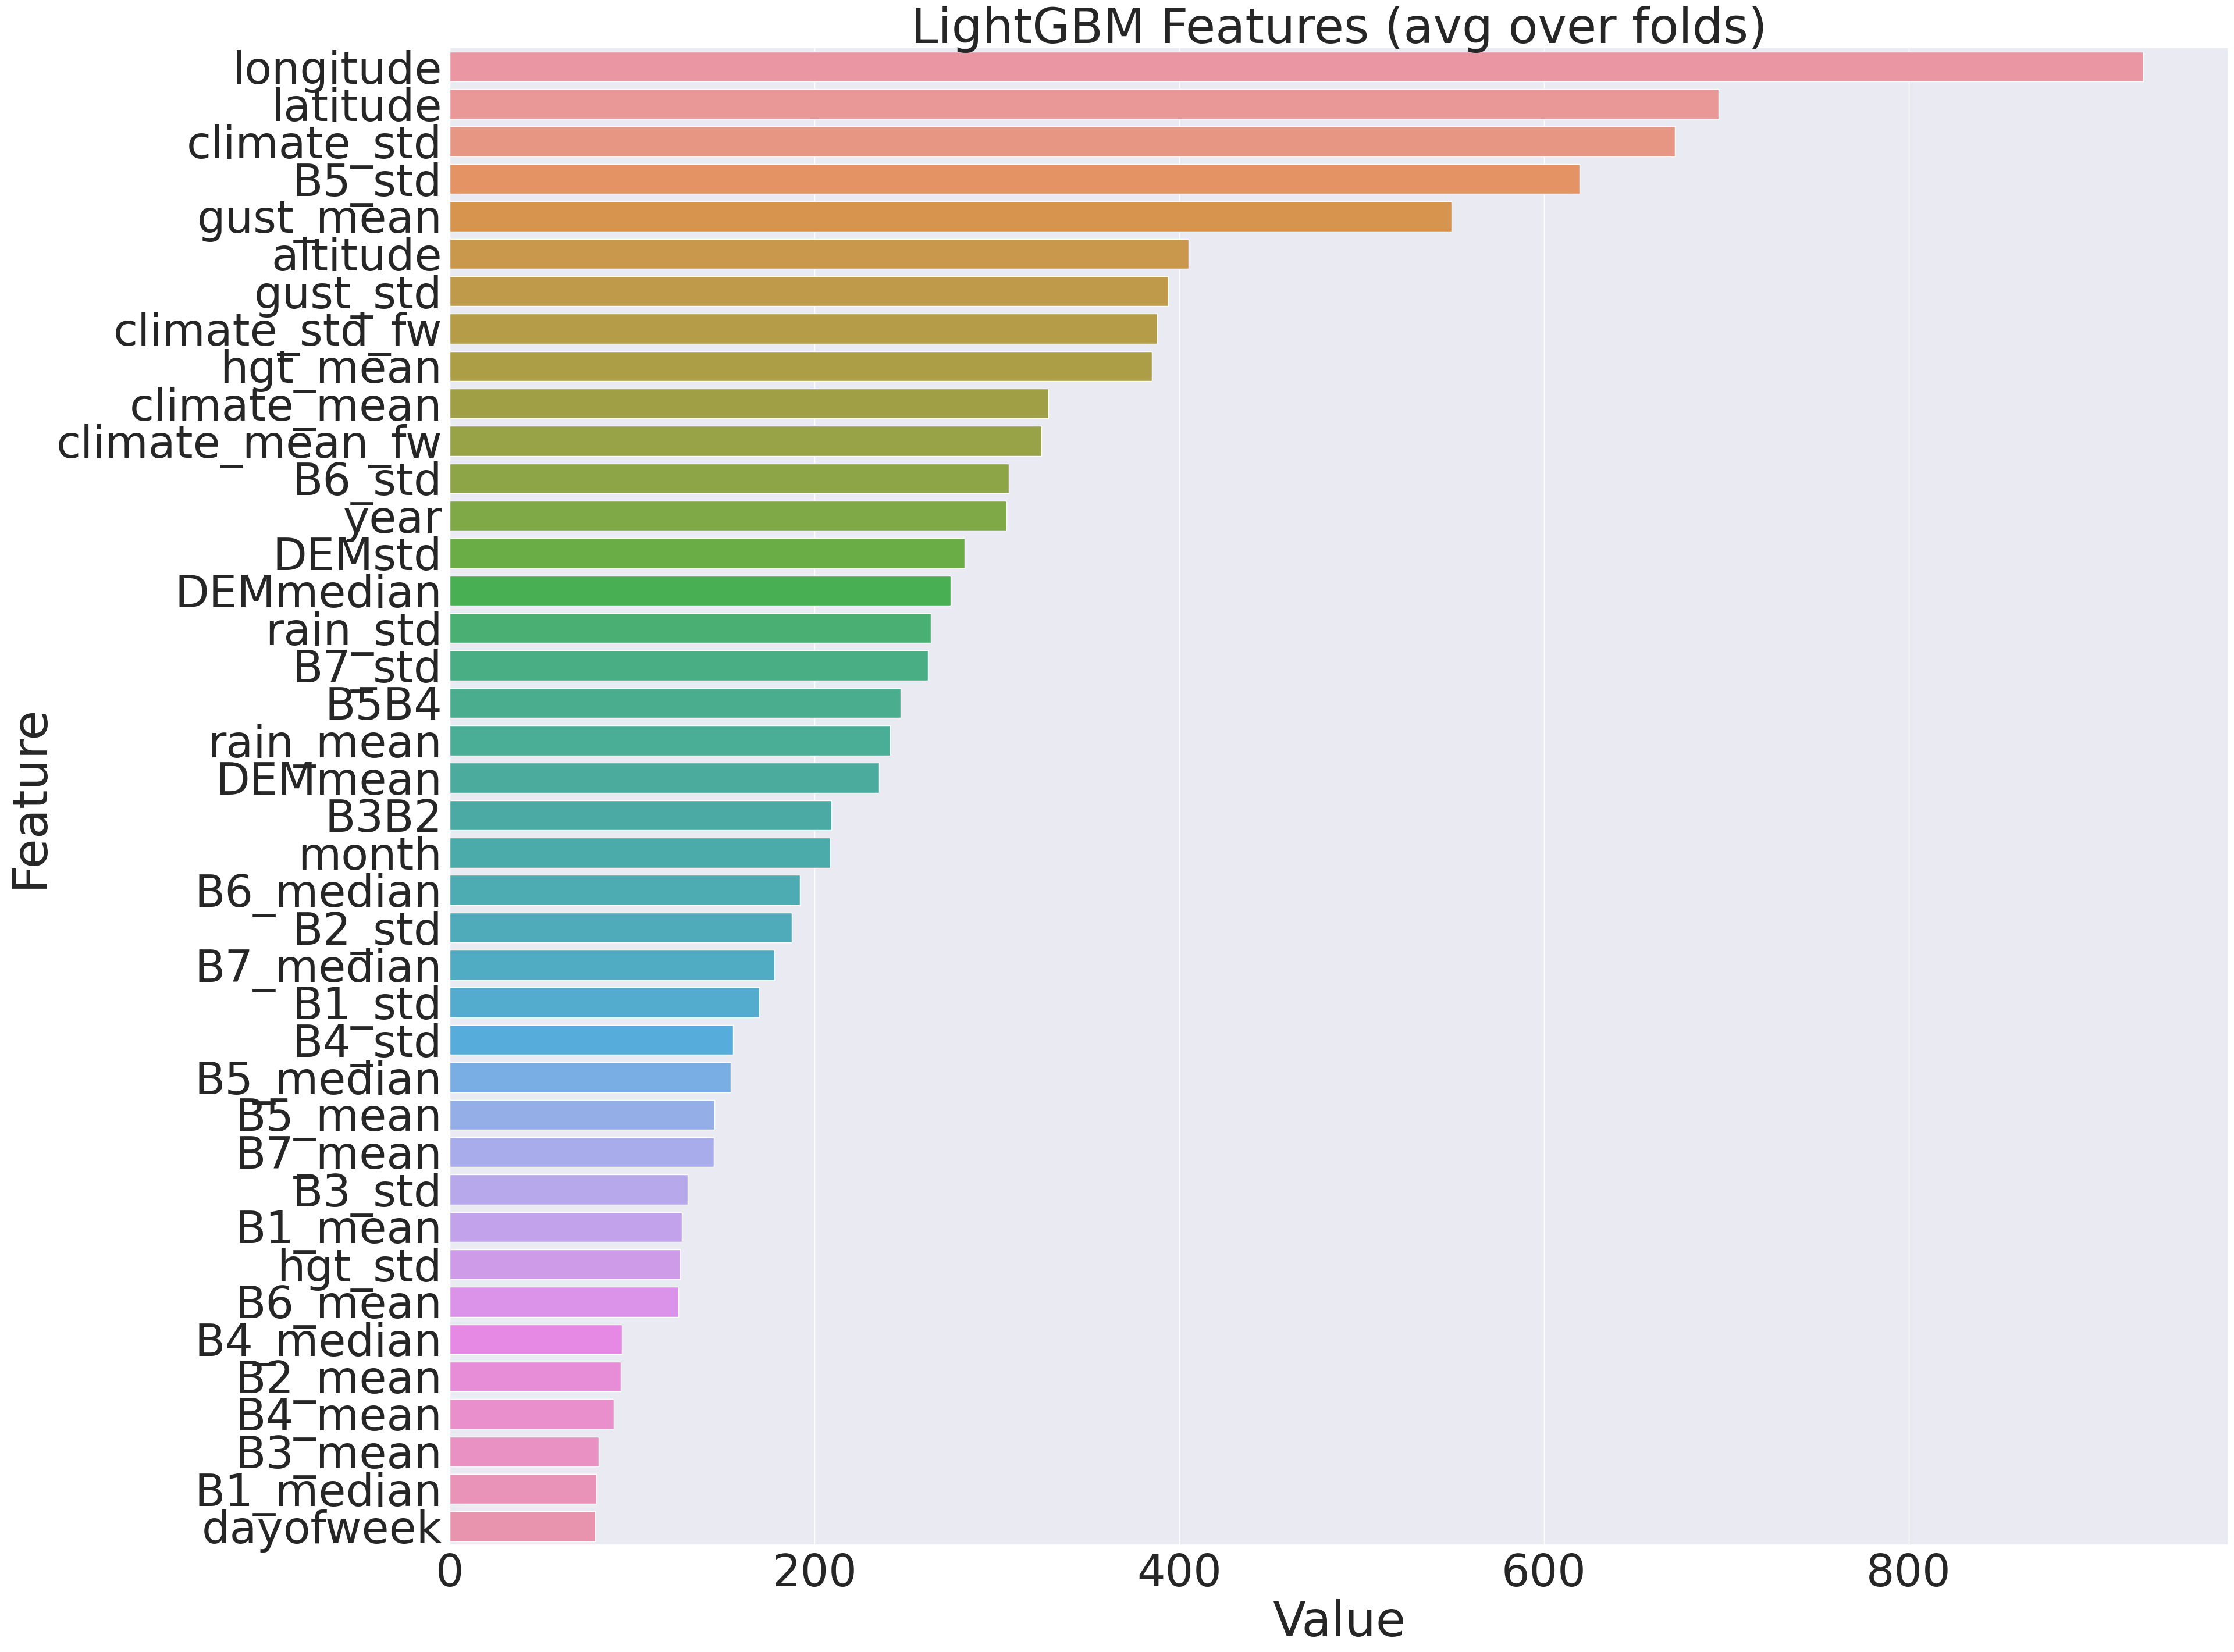

In [175]:
plotImp(np.array([posImp,dateImp,geomImp,climaImp,satImp]), ['posImp','dateImp','geomImp','climaImp','satImp'],
        num=10,fig_size = (30, 10))    
plotImp(mfis, feature_cols, num=40,fig_size = (40, 30)) 

In [177]:
oof2=oof.copy()
test_preds2=test_preds.copy()

In [178]:
score_oofs(oof2, imstatfeaturesStrain)

RMSE for south (n=9948): 0.7974
RMSE for west (n=3769): 0.414
RMSE for northeast (n=1143): 0.8829
RMSE for midwest (n=2200): 0.8666
Final score: 0.74020899147085
all mean 0.7467789370180039
---------------------------------------------


In [180]:
# all OOF
val_set = train_data[["uid", "region", "severity"]].copy()
# val_set["pred"] = np.clip((val_preds).astype(int),1,4)
optR = OptimizedRounder()
optR.fit( oof, val_set["severity"])
coefficients = optR.coefficients()
oofb = optR.predict( oof, coefficients)

# val_set["pred"] = np.clip((val_preds).astype(int),1,4)
val_set["pred"] = np.clip(np.round(oofb).astype(int),1,4)
# val_set["pred"] = np.clip(np.round(oof).astype(int),1,4)
# val_set["pred"] = np.clip(np.round((oof+oof2)/2).astype(int),1,4)

region_scores = []
for region in val_set.region.unique():
    sub = val_set[val_set.region == region]
    region_rmse = mean_squared_error(sub.severity, sub.pred, squared=False)
    print(f"RMSE for {region} (n={len(sub)}): {round(region_rmse, 4)}")
    region_scores.append(region_rmse)

overall_rmse = np.mean(region_scores)
print(f"Final score: {overall_rmse}")

# print("all mean",mean_squared_error(train_data.loc[:, target_col], np.clip(np.round((oof+oof2)/2).astype(int),1,4), squared=False))
print("all mean",mean_squared_error(train_data.loc[:, target_col], np.clip(np.round(oof).astype(int),1,4), squared=False))
print("---------------------------------------------")

RMSE for south (n=9948): 0.7974
RMSE for west (n=3769): 0.414
RMSE for northeast (n=1143): 0.8829
RMSE for midwest (n=2200): 0.8666
Final score: 0.74020899147085
all mean 1034.3532632960028
---------------------------------------------


In [185]:
# all OOF
val_set = train_data[["uid", "region", "severity"]].copy()

optR = OptimizedRounder()
optR.fit( (oof3+oof4)/2, val_set["severity"])
# optR.fit( (oof2+oof3+oof4)/3, val_set["severity"])
coefficients = optR.coefficients()
oofb = optR.predict( (oof3+oof4)/2, coefficients)
# oofb = optR.predict( (oof2+oof3+oof4)/3, coefficients)

# val_set["pred"] = np.clip((val_preds).astype(int),1,4)
val_set["pred"] = np.clip(np.round(oofb).astype(int),1,4)

# val_set["pred"] = np.clip(np.round((oof2+oof3+oof4)/3.).astype(int),1,4)


region_scores = []
for region in val_set.region.unique():
    sub = val_set[val_set.region == region]
    region_rmse = mean_squared_error(sub.severity, sub.pred, squared=False)
    print(f"RMSE for {region} (n={len(sub)}): {round(region_rmse, 4)}")
    region_scores.append(region_rmse)

overall_rmse = np.mean(region_scores)
print(f"Final score: {overall_rmse}")

# print("all mean",mean_squared_error(train_data.loc[:, target_col], np.clip(np.round((oof+oof2)/2).astype(int),1,4), squared=False))
# print("all mean",mean_squared_error(train_data.loc[:, target_col], np.clip(np.round((oof4+oof2)/2).astype(int),1,4), squared=False))
print("all mean",mean_squared_error(train_data.loc[:, target_col], np.clip(np.round((oof3+oof4)/2).astype(int),1,4), squared=False))
# print("all mean",mean_squared_error(train_data.loc[:, target_col], np.clip(np.round((oof3+oof2)/2).astype(int),1,4), squared=False))
print("---------------------------------------------")

RMSE for south (n=9948): 0.7597
RMSE for west (n=3769): 0.4088
RMSE for northeast (n=1143): 0.835
RMSE for midwest (n=2200): 0.8057
Final score: 0.7023201904832923
all mean 1034.351035975351
---------------------------------------------


In [189]:
coefficients

array([ 155.85302401,  438.63846112, 1156.21713718, 2647.26827148])

In [187]:
submission = submission_format.loc[:,['uid','region','severity']]
submission["severity"] = np.clip(np.round(optR.predict( (test_preds3+test_preds4)/2, coefficients)).astype(int),1,4)
submission=submission.set_index('uid')
submission.head()

# # # save out our formatted submission
# submission_save_path = "3LgbmsgkfKM20_ee_S_v42.csv"
# # submission_save_path = "Lgbmextragkf"+str(len(feature_colsSL))+"f_cl90buf30days400mb5K_v1.csv"
# submission.to_csv(submission_save_path, index=True)


,region,severity
uid,,
aabn,west,4
aair,west,3
aajw,northeast,2
aalr,midwest,3
aalw,west,3


In [190]:
submission.severity.value_counts()

2    2412
3    1966
4    1460
1     672
Name: severity, dtype: int64

In [191]:
(train_data.loc[:, 'severity']).value_counts(),np.unique(np.clip(np.round(oofb).astype(int),1,4),return_counts=True)


(1.0    7497
 4.0    3547
 2.0    3239
 3.0    2719
 5.0      58
 Name: severity, dtype: int64,
 (array([1, 2, 3, 4]), array([5629, 6291, 1706, 3434])))

In [192]:
from sklearn.metrics import confusion_matrix as cm
cm(train_data.loc[:, 'severity'], np.clip(np.round(oofb).astype(int),1,5))


array([[4532, 2750,  196,   18,    1],
       [ 841, 2024,  343,   24,    7],
       [ 251, 1414,  826,  221,    7],
       [   5,   96,  314, 3124,    8],
       [   0,    7,   27,   22,    2]])

In [193]:
(train_data.loc[:, 'severity']).value_counts(),np.unique(np.clip(np.round(oofb).astype(int),1,4),return_counts=True)


(1.0    7497
 4.0    3547
 2.0    3239
 3.0    2719
 5.0      58
 Name: severity, dtype: int64,
 (array([1, 2, 3, 4]), array([5629, 6291, 1706, 3434])))

In [195]:
folding=imstatfeaturesStrain.reset_index(drop=True).loc[:,['uid','fold']]
folding.head()

,uid,fold
0,vftu,4.0
1,bajg,0.0
2,erwt,2.0
3,coqu,0.0
4,xjei,0.0


In [196]:
np.mean(rgbsS,(0,1,2))#.shape

array([176.6920277 , 116.61178149, 107.81601166,  82.83744739,
       140.43478809, 114.86324059,  89.36771864])

In [197]:
RESIZE_SIZE=32
avgimageS=(np.zeros((RESIZE_SIZE,RESIZE_SIZE,7))+np.mean(rgbsS,(0,1,2))).astype('uint8')

In [198]:
uid_without_rgbsS=[x for x in metadata.uid if x not in idsS]
len(uid_without_rgbsS),uid_without_rgbsS[:5]

(440, ['hxuk', 'yuug', 'gulq', 'ifnv', 'zxma'])

In [199]:
rgbsSE=np.zeros((len(metadata),RESIZE_SIZE,RESIZE_SIZE,7),dtype='uint8')
rgbsSE[metadata.uid.isin(idsS),...]=rgbsS
rgbsSE[~metadata.uid.isin(idsS),...]=avgimageS


In [201]:
# DEM_DATA_DIR = "benchmark/dem/"
# DEM_DATA_DIR = "benchmark/dem2K/"

# # DEM_RESIZE_SIZE=128
# DEM_RESIZE_SIZE=32
# rgbDEM0=[]
# for f in tqdm(geomorthology_files):
# # for row in tqdm(metadata_subset.iloc[:2,:].itertuples(), total=2):
#     im = cv2.imread(DEM_DATA_DIR+f, cv2.IMREAD_GRAYSCALE)

#     if im.max()!=im.min():
#         im=(im-im.min())/(im.max()-im.min())
#     else:
#         im*=0
#     im=cv2.resize(im,(RESIZE_SIZE, RESIZE_SIZE))
#     rgbDEM0.append((im*255).astype('uint8'))
        
# rgbDEM0=np.stack(rgbDEM0)   
rgbDEM0=rgbDEM
rgbDEM0.shape

(23556, 32, 32)

In [202]:
rgbDEM.shape,metadata.shape

((23556, 32, 32), (23570, 56))

In [205]:
# plt.figure(figsize=(3,3))
# plt.imshow(rgbDEM0[0])
# plt.show()

In [206]:
# altDF0=pd.DataFrame(np.stack([[('_').join(x.split('_')[:2]),float(x.split('_')[-1][3:-4])] for x in geomorthology_files]),columns=['latlong','altitude'])
altDF0=altDF
altDF0.head()


,uid,altitude,DEMmean,DEMmedian,DEMstd
0,oeuw,123,108.174279,104.5,47.364784
1,tjhp,19,107.601538,103.0,33.233621
2,crel,8,62.676179,40.0,64.743936
3,zqhi,85,109.822581,105.0,54.010357
4,estg,-4,62.576923,46.0,50.925415


In [207]:
DEM_RESIZE_SIZE

32

In [209]:
avgimageD=(np.zeros((DEM_RESIZE_SIZE,DEM_RESIZE_SIZE))+np.mean(rgbDEM0)).astype('uint8')

In [210]:
rgbDEM0E=np.zeros((len(metadata),DEM_RESIZE_SIZE,DEM_RESIZE_SIZE),dtype='uint8')
rgbDEM0E[metadata.uid.isin(altDF0.uid),...]=rgbDEM0
rgbDEM0E[~metadata.uid.isin(altDF0.uid),...]=avgimageD

In [211]:
rgbDEM0E=np.expand_dims(rgbDEM0E,-1)

In [212]:
np.where(np.sum(rgbDEM0E,(1,2))==0)[0].shape

(1115,)

In [213]:
gc.collect()
# rgbCLIM.shape,rgbCLIME.shape

14877

In [214]:

import tensorflow as tf
import tensorflow.keras as keras

#from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Bidirectional, LSTM, Embedding, Dropout, Concatenate, Flatten, BatchNormalization
# from tensorflow.keras.layers import LSTM, Reshape, Bidirectional, concatenate
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, SeparableConv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, AveragePooling1D
from tensorflow.keras.models import Model
import gc
from tensorflow.keras.callbacks import LearningRateScheduler
    
# from tensorflow.keras.applications import EfficientNetB1
# from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Input, Concatenate, Conv2D, Dropout, Reshape
# from tensorflow.keras.layers import RandomTranslation, RandomContrast

from tensorflow.keras import regularizers
import tensorflow.keras.backend as K


from tensorflow.keras.applications import DenseNet201,EfficientNetB0


In [215]:
RESIZE_SIZE

32

In [216]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,VerticalFlip,
    RandomBrightness, RandomContrast, RandomGamma,RandomBrightnessContrast,
    ToFloat, ShiftScaleRotate
)
import cv2

AUGMENTATIONS_TRAIN = Compose([
    VerticalFlip(p=0.5),
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.5),
    HueSaturationValue(p=.5),
])


def transform(image):
    aug = AUGMENTATIONS_TRAIN
    return aug(image=image)['image']


from keras.preprocessing.image import ImageDataGenerator

# Define the image transformations here - keras generator
gen = ImageDataGenerator(
#                          preprocessing_function=transform,
                        #  rescale=1.,   
                         horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.2,
                         rotation_range = 0.0
                         )




def augmentGenerator2sw(X, X_num, X_time, y, sw, batch_size):
    
    genX1 = gen.flow(X, y,  batch_size=batch_size, seed=777)
    genX2 = gen.flow(X, X_num,  batch_size=batch_size, seed=777)
    genX3 = gen.flow(X, X_time,  batch_size=batch_size, seed=777)
    genX4 = gen.flow(X, sw,  batch_size=batch_size, seed=777)
    while True:
        X1i = genX1.next()
        X2 = genX2.next()[1]
        X3 = genX3.next()[1]
        X4 = genX4.next()[1]
        yield [X1i[0], X2, X3], X1i[1], X4 
    

In [217]:
# LR schedule
epochs=25
SNAPSHOTS=1
lr_0=0.001
BATCH_SIZE=64
verbose=1
best=False
epochspersnapshot = int(epochs/SNAPSHOTS)
def _cosine_anneal_schedule(t):
    cos_inner = np.pi * (t % (epochs // SNAPSHOTS))
    cos_inner /= epochs // SNAPSHOTS
    cos_out = np.cos(cos_inner) + 1
    return float(lr_0 / 2 * cos_out)
lr_anneal = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)
np.array([_cosine_anneal_schedule(t) for t in range( int(epochs/SNAPSHOTS))])

array([1.00000000e-03, 9.96057351e-04, 9.84291581e-04, 9.64888243e-04,
       9.38153340e-04, 9.04508497e-04, 8.64484314e-04, 8.18711995e-04,
       7.67913397e-04, 7.12889646e-04, 6.54508497e-04, 5.93690657e-04,
       5.31395260e-04, 4.68604740e-04, 4.06309343e-04, 3.45491503e-04,
       2.87110354e-04, 2.32086603e-04, 1.81288005e-04, 1.35515686e-04,
       9.54915028e-05, 6.18466600e-05, 3.51117571e-05, 1.57084194e-05,
       3.94264934e-06])

In [219]:
metadata.columns

Index(['uid', 'latitude', 'longitude', 'date', 'split', 'season', 'region',
       'severity', 'density', 'latlong', 'latlong1', 'latlong0', 'latlong10',
       'latlong0div3', 'latlong0div5', 'latlong0div6', 'latlong0div10',
       'altitude', 'DEMmean', 'DEMmedian', 'DEMstd', 'lattimeslong',
       'Kmeans40', 'Kmeans200', 'Kmeans80', 'Kmeans20', 'Kmeans25',
       'use_for_train', 'season_num', 'month', 'year', 'dayofweek',
       'climate_mean', 'climate_median', 'climate_std', 'climate_mean_fw',
       'climate_median_fw', 'climate_std_fw', 'rain_mean', 'rain_median',
       'rain_std', 'gust_mean', 'gust_median', 'gust_std', 'snowc_mean',
       'snowc_median', 'snowc_std', 'hgt_mean', 'hgt_median', 'hgt_std',
       'fold', 'Kmeans80_mean_severity', 'Kmeans200_mean_severity',
       'month_mean_severity', 'year_mean_severity', 'density_sqr'],
      dtype='object')

In [333]:
metadata2=metadata.loc[:,['uid','month']].copy()
metadata2=metadata2.merge(climIdsSeries,how='left')
metadata2=metadata2.merge(climIdsSeriesR,how='left')
metadata2=metadata2.merge(climIdsSeriesG,how='left')
metadata2=metadata2.merge(climIdsSeriesS,how='left')
metadata2=metadata2.merge(climIdsSeriesH,how='left')
metadata2.iloc[:,2:]=metadata2.iloc[:,2:].astype(float)


In [334]:
# metadata2.dtypes

In [224]:
def fillmeanpermonthNans(df, feature):
    for month in range(1,13):
        df.loc[(df[feature].astype(str)=='nan')&(df['month']==month),feature]=df.loc[(df[feature].astype(str)!='nan')&(df['month']==month),feature].mean()
    return df
for feature in metadata2.columns[2:]:
    metadata2 = fillmeanpermonthNans(metadata2, feature)
    

In [225]:
# metadata2

In [226]:
metadata2.describe()

,month,Temp0,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,Temp7,Temp8,...,HGT18,HGT19,HGT20,HGT21,HGT22,HGT23,HGT24,HGT25,HGT26,HGT27
count,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000,...,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000
mean,6.769750,16.847989,16.816286,16.689113,16.486701,16.516177,16.666249,16.663853,16.586847,16.428260,...,199.989286,199.989286,199.989286,199.989286,199.989286,199.989003,199.989003,199.989003,199.989003,199.986998
std,2.673005,8.524387,8.342050,8.438002,8.588021,8.627246,8.541747,8.378028,8.614217,8.725908,...,270.285859,270.285859,270.285859,270.285859,270.285859,270.285971,270.285971,270.285971,270.285971,270.285954
min,1.000000,-11.440000,-10.680000,-9.920000,-16.480000,-15.640000,-17.680000,-9.920000,-11.000000,-13.560000,...,0.015152,0.015152,0.015152,0.015152,0.015152,0.015152,0.015152,0.015152,0.015152,0.015152
25%,5.000000,9.500000,9.876250,9.680000,9.400000,9.160000,9.805000,9.880000,9.320000,9.520000,...,102.602564,102.602564,102.602564,102.602564,102.602564,102.602564,102.602564,102.602564,102.602564,102.602564
50%,7.000000,18.520000,18.302837,17.955000,18.179049,18.432343,18.280000,18.400000,18.555000,17.960000,...,123.053254,123.053254,123.053254,123.053254,123.053254,123.053254,123.053254,123.053254,123.053254,123.053254
75%,8.000000,24.040000,23.920000,23.720000,23.687500,23.520000,23.760000,23.640000,23.760000,23.800000,...,233.270833,233.270833,233.270833,233.270833,233.270833,233.270833,233.270833,233.270833,233.270833,233.270833
max,12.000000,36.240000,36.400000,34.733333,35.760000,35.000000,35.560000,36.040000,36.240000,34.800000,...,3389.534722,3389.534722,3389.534722,3389.534722,3389.534722,3389.534722,3389.534722,3389.534722,3389.534722,3389.534722


In [227]:
clima_in_time=np.reshape(metadata2.iloc[:,2:].values,(len(metadata2), 28, int(metadata2.shape[1]/28)),order='A')
clima_in_time.shape

(23570, 28, 5)

In [228]:
np.mean(clima_in_time,(0,1)),np.std(clima_in_time,(0,1))

(array([1.65240171e+01, 1.33975633e-01, 4.71565283e+00, 5.88146059e-01,
        1.99994063e+02]),
 array([  8.61145578,   0.29077552,   2.87795403,   6.03213776,
        270.2785405 ]))

In [229]:
clima_in_time=(clima_in_time-np.mean(clima_in_time,(0,1)))/np.std(clima_in_time,(0,1))

In [230]:
np.min(clima_in_time,(0,1))

array([-5.35612308, -0.46075279, -1.63854349, -0.09750209, -0.73989933])

In [231]:
def fillmeanpermonth(df, feature):
    for month in range(1,13):
        df.loc[(df[feature]==-999)&(df['month']==month),feature]=df.loc[(df[feature]!=-999)&(df['month']==month),feature].mean()
    return df


In [232]:
metadata2=metadata.copy()

metadata2['altitude']=metadata2['altitude'].fillna(metadata2['altitude'].median())
metadata2.loc[metadata2['altitude']==-1,'altitude']=metadata2.loc[metadata2['altitude']==-1,'altitude'].fillna(metadata2.loc[metadata2['altitude']!=-1,'altitude'].median())


use_cols=[ 'latitude', 
          'longitude', 
    'month_mean_severity',
    'year_mean_severity',
            'altitude', 'DEMstd','DEMmean','DEMmedian',
            ]


metadata_train_featsE=metadata2.loc[metadata2['split']=='train', use_cols ]
metadata_test_featsE=metadata2.loc[metadata2['split']=='test', use_cols]


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(np.concatenate((metadata_train_featsE,metadata_test_featsE)))
metadata_train_featsE=scaler.transform(metadata_train_featsE.values)
metadata_test_featsE=scaler.transform(metadata_test_featsE.values)

metadata_test_featsE


array([[ 0.67249387,  0.36068916, -0.96584926, ...,  2.00184961,
        -0.14065815,  0.26271938],
       [-0.30941006, -1.69355082,  1.12622075, ..., -0.50525823,
         0.17642132,  0.13691643],
       [ 1.48862825,  0.79635532, -0.96584926, ...,  0.21906175,
         0.749724  ,  0.73162128],
       ...,
       [-0.37506627,  0.69178739, -1.3183574 , ..., -0.60094318,
         1.71814867,  1.6008053 ],
       [-0.32116727, -1.6879041 , -0.04755108, ...,  0.8516757 ,
         0.57258114,  0.89173413],
       [-0.93544597, -1.63210782, -0.0112825 , ...,  0.59262992,
        -0.95056195, -1.26978929]])

In [233]:
# [x for x in use_cols if x.startswith('DEM')]
morf_col_nums=np.array([np.where(np.array(use_cols)==x)[0][0] for x in ['DEMstd','DEMmean','DEMmedian']])
not_morf_col_nums=np.array([x for x in range(len(use_cols)) if x not in morf_col_nums])
not_morf_col_nums

array([0, 1, 2, 3, 4])

In [234]:
metadata_train_usefortrain=metadata2.loc[metadata2['split']=='train', 'use_for_train' ].reset_index(drop=True)
metadata_train_usefortrain.head()

0    1
1    1
2    0
3    1
4    0
Name: use_for_train, dtype: int64

In [235]:
clima_in_time_train=clima_in_time[metadata2['split']=='train', ... ]
clima_in_time_test=clima_in_time[metadata2['split']=='test', ...]
clima_in_time_train.shape,clima_in_time_test.shape

((17060, 28, 5), (6510, 28, 5))

In [236]:
metadata2.loc[metadata2['split']=='train',[ 'severity', 'DEMstd','DEMmean']].head()

,severity,DEMstd,DEMmean
0,1.0,46.552843,119.423077
1,2.0,47.037722,145.014141
2,2.0,45.504411,102.120192
3,2.0,77.049538,66.557692
4,1.0,36.656130,79.747596


In [237]:
metadata2.columns

Index(['uid', 'latitude', 'longitude', 'date', 'split', 'season', 'region',
       'severity', 'density', 'latlong', 'latlong1', 'latlong0', 'latlong10',
       'latlong0div3', 'latlong0div5', 'latlong0div6', 'latlong0div10',
       'altitude', 'DEMmean', 'DEMmedian', 'DEMstd', 'lattimeslong',
       'Kmeans40', 'Kmeans200', 'Kmeans80', 'Kmeans20', 'Kmeans25',
       'use_for_train', 'season_num', 'month', 'year', 'dayofweek',
       'climate_mean', 'climate_median', 'climate_std', 'climate_mean_fw',
       'climate_median_fw', 'climate_std_fw', 'rain_mean', 'rain_median',
       'rain_std', 'gust_mean', 'gust_median', 'gust_std', 'snowc_mean',
       'snowc_median', 'snowc_std', 'hgt_mean', 'hgt_median', 'hgt_std',
       'fold', 'Kmeans80_mean_severity', 'Kmeans200_mean_severity',
       'month_mean_severity', 'year_mean_severity', 'density_sqr'],
      dtype='object')

In [238]:
metadata_train_featsE.shape

(17060, 8)

In [239]:
for i in range(metadata_train_featsE.shape[1]):
    print(use_cols[i],np.corrcoef(metadata_train_featsE[:,i],metadata.severity.loc[metadata2['split']=='train'])[0,1])

latitude 0.15333758687576815
longitude -0.7480732376478013
month_mean_severity 0.13034943154670256
year_mean_severity 0.10064846787690725
altitude -0.1229513315502832
DEMstd -0.0669835665920667
DEMmean -0.07735039307784236
DEMmedian -0.08397425856097018


In [240]:
for i in range(metadata_train_featsE.shape[1]):
    print(use_cols[i],np.corrcoef(metadata_train_featsE[:,i],metadata.density.loc[metadata2['split']=='train'])[0,1])

latitude 0.05214161916901059
longitude -0.22785382736810816
month_mean_severity 0.050008982464111534
year_mean_severity 0.01460060371866844
altitude -0.017554541466413807
DEMstd -0.0347081811214771
DEMmean -0.028049259556928836
DEMmedian -0.03478835376571098


In [241]:
for i in range(metadata_train_featsE.shape[1]):
    print(use_cols[i],np.corrcoef(metadata_train_featsE[:,i],(metadata.density.loc[metadata2['split']=='train'])**0.5)[0,1])

latitude 0.14074401000159095
longitude -0.7735239566539298
month_mean_severity 0.16924859444059817
year_mean_severity 0.07563890204382823
altitude -0.1272556691321754
DEMstd -0.1433429753687599
DEMmean -0.062247304985705645
DEMmedian -0.060958712252084546


In [242]:
for i in range(metadata_train_featsE.shape[1]):
    print(use_cols[i],np.corrcoef(metadata_train_featsE[:,i],(metadata.density.loc[metadata2['split']=='train'])**0.25)[0,1])

latitude 0.13643502198128432
longitude -0.8094793749481289
month_mean_severity 0.1600560835300889
year_mean_severity 0.09651068508053987
altitude -0.14170922940443562
DEMstd -0.11025774747907104
DEMmean -0.060356469569074096
DEMmedian -0.06325016944208636


In [245]:
regions=metadata2.loc[metadata.split=='train',[ 'uid', 'region']].reset_index(drop=True)
regions.head(),regions.shape

(    uid region
 0  vftu  south
 1  bajg   west
 2  erwt  south
 3  coqu  south
 4  xjei  south,
 (17060, 2))

In [246]:
region_counts=regions.groupby('region').count()['uid'].to_dict()
print(region_counts)

ADD_SMOOTH=0
region_weights={}
for region in region_counts:
    region_weights[region]=ADD_SMOOTH+600*len(region_counts)/region_counts[region]
print(region_weights    )
train_sample_weight0=regions.loc[:, 'region'].apply(lambda x: region_weights[x]).values

ADD_SMOOTH=0.5
region_weights={}
for region in region_counts:
    region_weights[region]=ADD_SMOOTH+200*len(region_counts)/region_counts[region]
print(region_weights    )
train_sample_weight=regions.loc[:, 'region'].apply(lambda x: region_weights[x]).values


train_sample_weight

{'midwest': 2200, 'northeast': 1143, 'south': 9948, 'west': 3769}
{'midwest': 1.0909090909090908, 'northeast': 2.099737532808399, 'south': 0.24125452352231605, 'west': 0.6367736800212258}
{'midwest': 0.8636363636363636, 'northeast': 1.1999125109361328, 'south': 0.5804181745074387, 'west': 0.7122578933404086}


array([0.58041817, 0.71225789, 0.58041817, ..., 0.58041817, 0.58041817,
       0.58041817])

In [247]:
train_sample_weight.shape,train_sample_weight0.shape

((17060,), (17060,))

In [337]:
RESIZE_SIZE2=32

In [335]:
from tensorflow.keras.applications import DenseNet201,EfficientNetB3,EfficientNetB1,EfficientNetB5


def get_model_cnnCH_extra_time_v10(num_outputs=1, dim=(RESIZE_SIZE, RESIZE_SIZE, 6), 
                              dim2=(metadata_train_featsE.shape[1],),
                              dim3=(clima_in_time_train.shape[1:]),):
    
    # create the base pre-trained model


    img_input = Input(shape=dim)
    num_input = Input(shape=dim2)
    time_feats = Input(shape=dim3)

    C3 = Conv2D(3, 3,padding='same')(img_input)
#     base_model = EfficientNetB5(weights='imagenet', include_top=False,
    base_model = EfficientNetB3(weights='imagenet', include_top=False,
#                                  input_tensor=img_conc
                                # input_shape=(500,500,3)
    )(C3)

#     x = base_model.output


    # add a global spatial average pooling layer
    
#     x0 = GlobalMaxPooling2D()(base_model)
    x = GlobalAveragePooling2D()(base_model)
#     x = Concatenate()([x0, x1])
    x = Dropout(0.1)(x)
    x= BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    
    xn = Dense(64, activation='relu')(num_input)
    xn= BatchNormalization()(xn)
    xn = Dropout(0.1)(xn)
    xn = Dense(64, activation='relu')(xn)
    xn= BatchNormalization()(xn)
    
    xt = Bidirectional(LSTM(64, return_sequences=False))(time_feats)
    xt= BatchNormalization()(xt)
    xt = Dropout(0.1)(xt)
    xt = Dense(64, activation='relu')(xt)
    xt= BatchNormalization()(xt)
    
    x = Concatenate()([x, xn, xt])
    
    # let's add a fully-connected layer
    
    x = Dropout(0.1)(x)
    x= BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x= BatchNormalization()(x)
    predictions = Dense(num_outputs, activation='linear')(x)

    # this is the model we will train
    model = Model(inputs=[img_input, num_input, time_feats], outputs=predictions)
    # model = Model(inputs=base_model.input, outputs=predictions)
    return model

model=get_model_cnnCH_extra_time_v10()
# model=get_model_cnn_v2()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 6)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 3)    165         ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 5)]      0           []                               
                                                                                              

In [253]:
import random

def set_seed_pt(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

    
def set_seed_tf(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
#     tf.set_random_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")



In [254]:
# LR schedule
epochs=40
SNAPSHOTS=1
lr_0=0.001
BATCH_SIZE=64
verbose=1
best=False
epochspersnapshot = int(epochs/SNAPSHOTS)
def _cosine_anneal_schedule(t):
    cos_inner = np.pi * (t % (epochs // SNAPSHOTS))
    cos_inner /= epochs // SNAPSHOTS
    cos_out = np.cos(cos_inner) + 1
    return float(lr_0 / 2 * cos_out)
lr_anneal = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)
np.array([_cosine_anneal_schedule(t) for t in range( int(epochs/SNAPSHOTS))])

array([1.00000000e-03, 9.98458667e-04, 9.93844170e-04, 9.86184960e-04,
       9.75528258e-04, 9.61939766e-04, 9.45503262e-04, 9.26320082e-04,
       9.04508497e-04, 8.80202983e-04, 8.53553391e-04, 8.24724024e-04,
       7.93892626e-04, 7.61249282e-04, 7.26995250e-04, 6.91341716e-04,
       6.54508497e-04, 6.16722682e-04, 5.78217233e-04, 5.39229548e-04,
       5.00000000e-04, 4.60770452e-04, 4.21782767e-04, 3.83277318e-04,
       3.45491503e-04, 3.08658284e-04, 2.73004750e-04, 2.38750718e-04,
       2.06107374e-04, 1.75275976e-04, 1.46446609e-04, 1.19797017e-04,
       9.54915028e-05, 7.36799178e-05, 5.44967379e-05, 3.80602337e-05,
       2.44717419e-05, 1.38150398e-05, 6.15582970e-06, 1.54133313e-06])

In [255]:
RESIZE_SIZE

32

In [256]:
gc.collect()

60844

In [257]:
# metadata_train_usefortrain.shape,val_set_mask.shape

In [258]:
def evaluate_predsAll(oof):
    val_set = metadatatrainfold[ ["uid", "region", "severity"]].copy()
    # val_set["pred"] = np.clip((val_preds).astype(int),1,4)
    optR = OptimizedRounder()
    optR.fit( oof, val_set["severity"])
    coefficients = optR.coefficients()
    preds2 = optR.predict( oof, coefficients)

    # val_set["pred"] = np.clip((val_preds).astype(int),1,4)
    val_set["pred"] = np.clip(np.round(preds2).astype(int),1,4)
#     val_set["pred"] = np.clip(np.round(oof).astype(int),1,4)

    region_scores = []
    for region in val_set.region.unique():
        sub = val_set[val_set.region == region]
        region_rmse = mean_squared_error(sub.severity, sub.pred, squared=False)
        print(f"RMSE for {region} (n={len(sub)}): {round(region_rmse, 4)}")
        region_scores.append(region_rmse)

    overall_rmse = np.mean(region_scores)
    print(f"Final score: {overall_rmse}")

    print("all mean",mean_squared_error(metadatatrainfold.severity, np.clip(np.round(preds2).astype(int),1,4), squared=False))
    print("---------------------------------------------")
# evaluate_predsAll(oof)

In [259]:
RESIZE_SIZE

32

In [260]:
# LR schedule
epochs=60
SNAPSHOTS=2
lr_0=0.001
BATCH_SIZE=64
verbose=1
best=False
epochspersnapshot = int(epochs/SNAPSHOTS)
def _cosine_anneal_schedule(t):
    cos_inner = np.pi * (t % (epochs // SNAPSHOTS))
    cos_inner /= epochs // SNAPSHOTS
    cos_out = np.cos(cos_inner) + 1
    return float(lr_0 / 2 * cos_out)
lr_anneal = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)
np.array([_cosine_anneal_schedule(t) for t in range( int(epochs/SNAPSHOTS))])

array([1.00000000e-03, 9.97260948e-04, 9.89073800e-04, 9.75528258e-04,
       9.56772729e-04, 9.33012702e-04, 9.04508497e-04, 8.71572413e-04,
       8.34565303e-04, 7.93892626e-04, 7.50000000e-04, 7.03368322e-04,
       6.54508497e-04, 6.03955845e-04, 5.52264232e-04, 5.00000000e-04,
       4.47735768e-04, 3.96044155e-04, 3.45491503e-04, 2.96631678e-04,
       2.50000000e-04, 2.06107374e-04, 1.65434697e-04, 1.28427587e-04,
       9.54915028e-05, 6.69872981e-05, 4.32272712e-05, 2.44717419e-05,
       1.09261996e-05, 2.73905232e-06])

In [ ]:
name='EfNB3GKFkm20shim'+str(RESIZE_SIZE)+'ee_cnn6_mv10_time_S_targencC_DensSqR_ep60sn2_v42allW'  
# name='EfNB3GKF10im'+str(RESIZE_SIZE)+'bestof6_v11all'    
from keras import backend as K 


train_data=rgbsSE[metadata.split=='train'][...,1:]
# train_dataP=rgbsLE[metadata.split=='train'][...,1:]
test_data=rgbsSE[metadata.split=='test'][...,1:]

metadatatrainfold=metadata2.loc[metadata.split=='train',['fold', "uid", "region", "severity","density_sqr"]].reset_index(drop=True)


oof=np.zeros(len(train_data))
test_preds=np.zeros(len(test_data))
# NUM_FOLDS=5
for fold in range(NUM_FOLDS):
    set_seed_tf(42-fold)        

#     val_set_mask = train_labels.fold == fold
    val_set_mask = metadatatrainfold.fold == fold

    X_train = train_data[~val_set_mask, ...]
#     X_trainP = train_dataP[~val_set_mask, ...]
#     X_train_extra = metadata_train_feats.values[~val_set_mask,:]
    X_train_extra = metadata_train_featsE[~val_set_mask,:]
    X_train_time = clima_in_time_train[~val_set_mask,...]
#     y_train = metadata.severity.loc[metadata.split=='train'].values[~val_set_mask]
    y_train = metadata.density_sqr.loc[metadata.split=='train'].values[~val_set_mask]
    

    X_val = train_data[val_set_mask, :]
    X_val_extra = metadata_train_featsE[val_set_mask, :]
    X_val_time = clima_in_time_train[val_set_mask,...]
#     X_val_extra = metadata_train_feats.values[val_set_mask, :]
    y_val = metadata.density_sqr.loc[metadata.split=='train'].values[val_set_mask]
#     y_val = metadata.severity.loc[metadata.split=='train'].values[val_set_mask]

    print(X_train.shape,X_train_extra.shape,X_train_time.shape,y_train.shape, X_val.shape)

    model=get_model_cnnCH_extra_time_v10(dim=X_train.shape[1:],dim2=(metadata_train_featsE.shape[1],))
    # model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=lr_0, beta_1=0.8))
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=lr_0),
                 weighted_metrics=['RootMeanSquaredError'])


                    
    history = model.fit(augmentGenerator2sw(X_train, X_train_extra, X_train_time, y_train, 
#     history = model.fit(augmentGeneratorDual(X_train,X_trainP,  X_train_extra, y_train, 
                                          train_sample_weight[~val_set_mask], 
                                          BATCH_SIZE),
                        steps_per_epoch=int(np.ceil(X_train.shape[0]/BATCH_SIZE)),
#                         batch_size=BATCH_SIZE,
                        # epochs=40,
                        epochs=epochs,
                        shuffle=True,
                        validation_data=([X_val, X_val_extra, X_val_time], y_val,
#                                          train_sample_weight0[val_set_mask]
                                        ),
                        callbacks=[#lr_sch, 
                                lr_anneal,
                                tf.keras.callbacks.ModelCheckpoint('weights/'+name+'_fold'+str(fold)+'.h5',
                                                                    monitor='val_loss', verbose=0, save_best_only=True,
                                                                    save_weights_only=True, mode='auto', 
                                                                    save_freq='epoch',
#                                                                     period=10
                                                                  )
                        ],
                        verbose = verbose )
    model.save_weights('weights/'+name+'_fold'+str(fold)+'_last.h5')
    
#     if best==True:
    model.load_weights('weights/'+name+'_fold'+str(fold)+'.h5')

    # generate predictions
    preds = model.predict([X_val, X_val_extra, X_val_time])[:,0]
    test_preds += model.predict([test_data, metadata_test_featsE, clima_in_time_test])[:,0]/NUM_FOLDS
    oof[val_set_mask]=preds
    
    
    # get the validation part of the training data
#     val_set = train_data[train_data.fold == fold][
    val_set = metadatatrainfold[val_set_mask][
        ["uid", "region", "severity"]
    ].copy()
    
    optR = OptimizedRounder()
    optR.fit( preds, val_set["severity"])
    coefficients = optR.coefficients()
    preds2 = optR.predict( preds, coefficients)

    # val_set["pred"] = np.clip((val_preds).astype(int),1,4)
    val_set["pred"] = np.clip(np.round(preds2).astype(int),1,4)
    
#     val_set["pred"] = np.clip(np.round(preds).astype(int),1,4)

    region_scores = []
    for region in val_set.region.unique():
        sub = val_set[val_set.region == region]
        region_rmse = mean_squared_error(sub.severity, sub.pred, squared=False)
        print(f"RMSE for {region} (n={len(sub)}): {round(region_rmse, 4)}")
        region_scores.append(region_rmse)

    overall_rmse = np.mean(region_scores)
    print(f"Final score: {overall_rmse}")

    print("all mean",mean_squared_error(y_val, np.clip(np.round(preds).astype(int),1,4), squared=False))
    print("---------------------------------------------")
    

    del model
    gc.collect()
    K.clear_session()
    
    
    

Random seed set as 42
(7481, 32, 32, 6) (7481, 8) (7481, 28, 5) (7481,) (9579, 32, 32, 6)


/var/venv/cuda112py37/lib/python3.7/site-packages/keras/preprocessing/image.py:687: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (7481, 32, 32, 6) (6 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/60


2023-02-02 08:14:22.440805: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


117/117 [==============================] - 79s 419ms/step - loss: 812884.8750 - root_mean_squared_error: 1087.0414 - val_loss: 979162.3125 - val_root_mean_squared_error: 989.5263 - lr: 0.0010
Epoch 2/60
117/117 [==============================] - 44s 378ms/step - loss: 750718.6250 - root_mean_squared_error: 1044.6483 - val_loss: 924459.8125 - val_root_mean_squared_error: 961.4883 - lr: 9.9726e-04
Epoch 3/60
117/117 [==============================] - 43s 373ms/step - loss: 678476.4375 - root_mean_squared_error: 993.1135 - val_loss: 781357.8750 - val_root_mean_squared_error: 883.9445 - lr: 9.8907e-04
Epoch 4/60
117/117 [==============================] - 43s 371ms/step - loss: 595905.6250 - root_mean_squared_error: 930.7228 - val_loss: 648343.9375 - val_root_mean_squared_error: 805.1981 - lr: 9.7553e-04
Epoch 5/60
117/117 [==============================] - 43s 374ms/step - loss: 519287.5938 - root_mean_squared_error: 868.8314 - val_loss: 551408.5000 - val_root_mean_squared_error: 742.5688 

/var/venv/cuda112py37/lib/python3.7/site-packages/keras/preprocessing/image.py:687: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (15173, 32, 32, 6) (6 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/60
238/238 [==============================] - 103s 324ms/step - loss: 729412.3125 - root_mean_squared_error: 1030.4346 - val_loss: 962108.5000 - val_root_mean_squared_error: 980.8713 - lr: 0.0010
Epoch 2/60
238/238 [==============================] - 72s 304ms/step - loss: 584570.4375 - root_mean_squared_error: 922.4703 - val_loss: 738075.2500 - val_root_mean_squared_error: 859.1130 - lr: 9.9726e-04
Epoch 3/60
238/238 [==============================] - 71s 301ms/step - loss: 421102.8125 - root_mean_squared_error: 782.9391 - val_loss: 8975928.0000 - val_root_mean_squared_error: 2995.9854 - lr: 9.8907e-04
Epoch 4/60
238/238 [==============================] - 72s 305ms/step - loss: 299053.5312 - root_mean_squared_error: 659.7941 - val_loss: 328814.4688 - val_root_mean_squared_error: 573.4235 - lr: 9.7553e-04
Epoch 5/60
238/238 [==============================] - 72s 304ms/step - loss: 238745.3438 - root_mean_squared_error: 589.5239 - val_loss: 251560.6562 - val_root_mean_squared_err

/var/venv/cuda112py37/lib/python3.7/site-packages/keras/preprocessing/image.py:687: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (15201, 32, 32, 6) (6 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/60
238/238 [==============================] - 104s 325ms/step - loss: 701122.0625 - root_mean_squared_error: 1009.2730 - val_loss: 1240893.0000 - val_root_mean_squared_error: 1113.9537 - lr: 0.0010
Epoch 2/60
238/238 [==============================] - 72s 305ms/step - loss: 553381.5000 - root_mean_squared_error: 896.6524 - val_loss: 1042668.3125 - val_root_mean_squared_error: 1021.1113 - lr: 9.9726e-04
Epoch 3/60
238/238 [==============================] - 72s 303ms/step - loss: 391071.4688 - root_mean_squared_error: 753.7717 - val_loss: 791568.3125 - val_root_mean_squared_error: 889.7012 - lr: 9.8907e-04
Epoch 4/60
238/238 [==============================] - 71s 301ms/step - loss: 269041.8750 - root_mean_squared_error: 625.2041 - val_loss: 1050954.0000 - val_root_mean_squared_error: 1025.1604 - lr: 9.7553e-04
Epoch 5/60
238/238 [==============================] - 72s 302ms/step - loss: 202762.8438 - root_mean_squared_error: 542.7578 - val_loss: 619284.3750 - val_root_mean_squared

In [359]:
evaluate_predsAll(oof)

RMSE for south (n=9948): 0.8312
RMSE for west (n=3769): 0.4368
RMSE for northeast (n=1143): 0.8893
RMSE for midwest (n=2200): 0.8634
Final score: 0.7551728525182808
all mean 0.7708036943912643
---------------------------------------------


In [345]:
# X_train = rgbsSE[metadata.split=='train'][...,1:]
# metadatatrainfold=metadata2.loc[metadata.split=='train',['fold', "uid", "region", "severity","density_sqr"]].reset_index(drop=True)

# X_train.shape

In [270]:
def get_predictionTimeAll(name, USE_TTA=False, last_or_best='best', model0=get_model_cnnCH_extra_v10(dim=X_train.shape[1:],dim2=(metadata_train_featsE.shape[1],)),
                    train_data=train_data.copy(), test_data=test_data.copy()):

    oof=np.zeros(len(train_data))
    test_preds=np.zeros(len(test_data))
    # NUM_FOLDS=5
    
    for fold in range(NUM_FOLDS):


        val_set_mask = metadatatrainfold.fold == fold

        X_train = train_data[~val_set_mask, ...]
        X_train_extra = metadata_train_featsE[~val_set_mask,:]
        X_train_time = clima_in_time_train[~val_set_mask,...]
    #     X_train_emb = train_locations_enc[~val_set_mask]
        y_train = metadata.severity.loc[metadata.split=='train'].values[~val_set_mask]
        X_val = train_data[val_set_mask, :]
        X_val_extra = metadata_train_featsE[val_set_mask, :]
        X_val_time = clima_in_time_train[val_set_mask,...]
    #     X_val_emb = train_locations_enc[val_set_mask]
        y_val = metadata.severity.loc[metadata.split=='train'].values[val_set_mask]


    #     model=get_model_cnn_extra_v2(dim2=(metadata_train_feats.shape[1],))
        model=model0
        # model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=lr_0, beta_1=0.8))
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=lr_0))

        if last_or_best=='best':
            model.load_weights('weights/'+name+'_fold'+str(fold)+'.h5')
        else:
            model.load_weights('weights/'+name+'_fold'+str(fold)+'_last.h5')
            
    #     model.load_weights('weights/'+name+'_fold'+str(fold)+'_last.h5')

        # generate predictions
        if USE_TTA == False:
            preds = model.predict([X_val, X_val_extra, X_val_time])[:,0]
            test_preds += 1*model.predict([test_data, metadata_test_featsE,clima_in_time_test])[:,0]/NUM_FOLDS
            oof[val_set_mask]+=preds/1
        else:
            preds = model.predict([X_val, X_val_extra, X_val_time])[:,0]
            test_preds += 0.25*model.predict([test_data, metadata_test_featsE, clima_in_time_test])[:,0]/NUM_FOLDS
            oof[val_set_mask]+=preds/4

            preds = model.predict([X_val[:,::-1,...], X_val_extra, X_val_time])[:,0]
            test_preds += 0.25*model.predict([test_data[:,::-1,...], metadata_test_featsE, clima_in_time_test])[:,0]/NUM_FOLDS
            oof[val_set_mask]+=preds/4
            preds = model.predict([X_val[:,:,::-1,...], X_val_extra, X_val_time])[:,0]
            test_preds += 0.25*model.predict([test_data[:,:,::-1,...], metadata_test_featsE, clima_in_time_test])[:,0]/NUM_FOLDS
            oof[val_set_mask]+=preds/4
            preds = model.predict([X_val[:,::-1,::-1,:], X_val_extra, X_val_time])[:,0]
            test_preds += 0.25*model.predict([test_data[:,::-1,::-1,:], metadata_test_featsE, clima_in_time_test])[:,0]/NUM_FOLDS
            oof[val_set_mask]+=preds/4


        # get the validation part of the training data
    #     val_set = train_data[train_data.fold == fold][
        val_set = metadatatrainfold[val_set_mask][ ["uid", "region", "severity"]].copy()

        optR = OptimizedRounder()
        optR.fit( oof[val_set_mask], val_set["severity"])
        coefficients = optR.coefficients()
        preds2 = optR.predict( oof[val_set_mask], coefficients)

        # val_set["pred"] = np.clip((val_preds).astype(int),1,4)
        val_set["pred"] = np.clip(np.round(preds2).astype(int),1,4)
#         val_set["pred"] = np.clip(np.round(oof[val_set_mask]).astype(int),1,4)

        region_scores = []
        for region in val_set.region.unique():
            sub = val_set[val_set.region == region]
            region_rmse = mean_squared_error(sub.severity, sub.pred, squared=False)
            print(f"RMSE for {region} (n={len(sub)}): {round(region_rmse, 4)}")
            region_scores.append(region_rmse)

        overall_rmse = np.mean(region_scores)
        print(f"Final score: {overall_rmse}")

        print("all mean",mean_squared_error(y_val, np.clip(np.round(preds2).astype(int),1,4), squared=False))
        print("---------------------------------------------")
        
        del model
        gc.collect()
        K.clear_session()

    return oof, test_preds



In [273]:
name='EfNB3GKFkm20shim'+str(RESIZE_SIZE)+'ee_cnn6_mv10_time_S_targencC_DensSqR_ep60sn2_v42allW'  
oofallPtT, test_predsallPtT =  get_predictionTimeAll(name=name, USE_TTA=True, 
                    last_or_best='last',  model0=get_model_cnnCH_extra_time_v10(dim=X_train.shape[1:],dim2=(metadata_train_featsE.shape[1],)),
                  train_data=rgbsSE[...,1:][metadata.split=='train'].copy(), test_data=rgbsSE[...,1:][metadata.split=='test'].copy())


2023-09-08 08:11:12.578731: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


204/204 [==============================] - 6s 29ms/step
RMSE for west (n=2102): 0.428
RMSE for south (n=5573): 0.8506
RMSE for midwest (n=1287): 0.8628
RMSE for northeast (n=617): 0.8912
Final score: 0.7581195604526259
all mean 0.7824812174242092
---------------------------------------------
204/204 [==============================] - 6s 31ms/step
RMSE for northeast (n=142): 0.8881
RMSE for south (n=1071): 0.7844
RMSE for midwest (n=229): 0.918
RMSE for west (n=445): 0.416
Final score: 0.7516341442885893
all mean 0.7427444489023117
---------------------------------------------
204/204 [==============================] - 6s 30ms/step
RMSE for south (n=1133): 0.8142
RMSE for west (n=395): 0.4025
RMSE for northeast (n=126): 0.8591
RMSE for midwest (n=205): 0.9266
Final score: 0.7505929924641455
all mean 0.7636158710332139
---------------------------------------------
204/204 [==============================] - 6s 32ms/step
RMSE for south (n=1084): 0.8564
RMSE for west (n=418): 0.3943
RMSE fo

In [274]:
evaluate_predsAll(oofallPtT)

RMSE for south (n=9948): 0.8398
RMSE for west (n=3769): 0.415
RMSE for northeast (n=1143): 0.8744
RMSE for midwest (n=2200): 0.865
Final score: 0.7485462872309532
all mean 0.7726645785827658
---------------------------------------------


In [275]:
gc.collect()

31567

In [278]:
np.corrcoef(oofallPtT, oof2)

array([[1.       , 0.9121238],
       [0.9121238, 1.       ]])

In [279]:
# oof2.shape, oof3.shape
val_set = metadata.loc[metadata.split=='train', ["uid", "region", "severity",'use_for_train']].reset_index(drop=True)

# val_set["predprob"] = (oofallPtT+2*oof4)/3
# val_set["predprob"] = (oofallPtT+oof4)/2
val_set["predprob"] = (oofallPtT+oof4+oof3)/3

val_set["pred"] = np.clip(np.round(val_set["predprob"]).astype(int),1,4)
val_set=val_set.loc[val_set.use_for_train==1,:]

region_scores = []
for region in val_set.region.unique():
    sub = val_set[val_set.region == region]
    region_rmse = mean_squared_error(sub.severity, sub.pred, squared=False)
    print(f"RMSE for {region} (n={len(sub)}): {round(region_rmse, 4)}")
    region_scores.append(region_rmse)

overall_rmse = np.mean(region_scores)
print(f"Final score: {overall_rmse}")

print("---------------------------------------------")

RMSE for south (n=7699): 2.529
RMSE for west (n=3757): 0.7471
RMSE for northeast (n=1143): 2.3768
RMSE for midwest (n=2021): 2.0231
Final score: 1.9190076914236756
---------------------------------------------


In [280]:
val_set = metadata.loc[metadata.split=='train', ["uid", "region", "severity"]].reset_index(drop=True)

# val_set["predprob"] =(0.5*oofalltT3+0.5*oofallPtT3+2*((oof2+oof3+oof4)/3))/3
# val_set["predprob"] =(oofallPtT+2*oof2)/3
val_set["predprob"] = (oofallPtT+oof4+oof3)/3
# val_set["predprob"] =oof2
# val_set["predprob"] =oofallPtT


val_set["pred"] = np.clip(np.round(val_set["predprob"]).astype(int),1,4)

region_scores = []
for region in val_set.region.unique():
    sub = val_set[val_set.region == region]
    region_rmse = mean_squared_error(sub.severity, sub.pred, squared=False)
    print(f"RMSE for {region} (n={len(sub)}): {round(region_rmse, 4)}")
    region_scores.append(region_rmse)

overall_rmse = np.mean(region_scores)
print(f"Final score: {overall_rmse}")

print("---------------------------------------------")

RMSE for south (n=9948): 2.5552
RMSE for west (n=3769): 0.7537
RMSE for northeast (n=1143): 2.3768
RMSE for midwest (n=2200): 2.0351
Final score: 1.9302048104421479
---------------------------------------------


In [281]:
score_oofs(oofallPtT, metadata.loc[metadata.split=='train',:])

RMSE for south (n=9948): 0.8398
RMSE for west (n=3769): 0.415
RMSE for northeast (n=1143): 0.8744
RMSE for midwest (n=2200): 0.865
Final score: 0.7485462872309532
all mean 0.7726645785827658
---------------------------------------------


In [282]:
score_oofs((oofallPtT+oof4+oof3)/3, metadata.loc[metadata.split=='train',:])

RMSE for south (n=9948): 0.7632
RMSE for west (n=3769): 0.3983
RMSE for northeast (n=1143): 0.8224
RMSE for midwest (n=2200): 0.8163
Final score: 0.7000601851265753
all mean 0.7113219369645745
---------------------------------------------


In [283]:
score_oofs((oofallPtT+oof4+oof3+0.5*oof)/3.5, metadata.loc[metadata.split=='train',:])

RMSE for south (n=9948): 0.762
RMSE for west (n=3769): 0.3973
RMSE for northeast (n=1143): 0.8324
RMSE for midwest (n=2200): 0.8118
Final score: 0.700908148300869
all mean 0.7105799028671821
---------------------------------------------


In [284]:
score_oofs((oof2+oof4+oof3)/3, metadata.loc[metadata.split=='train',:])

RMSE for south (n=9948): 0.7677
RMSE for west (n=3769): 0.4178
RMSE for northeast (n=1143): 0.8361
RMSE for midwest (n=2200): 0.823
Final score: 0.7111454184797782
all mean 0.7186185783820089
---------------------------------------------


In [285]:
score_oofs((2*oofallPtT+2*oof4+oof3)/5, metadata.loc[metadata.split=='train',:])

RMSE for south (n=9948): 0.7617
RMSE for west (n=3769): 0.3993
RMSE for northeast (n=1143): 0.824
RMSE for midwest (n=2200): 0.7977
Final score: 0.6956824515968734
all mean 0.707893859484194
---------------------------------------------


In [286]:
score_oofs((2*oofallPtT+2*oof4+oof2)/5, metadata.loc[metadata.split=='train',:])

RMSE for south (n=9948): 0.7593
RMSE for west (n=3769): 0.3967
RMSE for northeast (n=1143): 0.8181
RMSE for midwest (n=2200): 0.8006
Final score: 0.6936667988850665
all mean 0.7060283047971078
---------------------------------------------


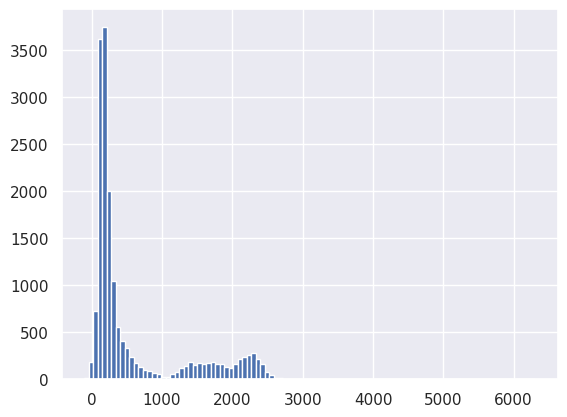

In [288]:
sns.set(font_scale = 1)
plt.hist(val_set["predprob"] ,100)
plt.show()

In [289]:
trPprobs=(oofallPtT+oof4+oof3)/3
optR = OptimizedRounder()
optR.fit( trPprobs, metadata.loc[metadata.split=='train','severity'])
coefficients = optR.coefficients()
# oofb = optR.predict( (oof3+oof4)/2, coefficients)
trP = optR.predict( trPprobs, coefficients)
trPprobs

array([139.73135944, 242.45800948, 168.24585358, ...,  97.52983521,
       384.75249738, 152.19966806])

In [295]:
max(trPprobs)

6307.178164453074

In [290]:
coefficients

array([ 180.50804671,  440.16307056,  978.93899671, 2926.13941879])

In [329]:
# plt.figure(figsize=(5,3))
# plt.hist(np.clip(trPprobs,0,3000) ,70)
# # plt.hist(trPprobs ,70)

# # plt.axvline(x=coefficients[1], )
# plt.vlines(x=coefficients, ymin=0, ymax=4000, colors='purple', ls='--', lw=1, label='vline_multiple - full height')

# plt.ylabel('Counts')
# plt.xlabel('Density square root')
# plt.show()

In [313]:
np.unique(trP,return_counts=True)

(array([1., 2., 3., 4., 5.]), array([6421, 5668, 1343, 3614,   14]))

In [318]:
cm(train_data.loc[:, 'severity'], np.clip(np.round(trP).astype(int),1,5))

array([[4975, 2347,  152,   22,    1],
       [1096, 1825,  275,   37,    6],
       [ 343, 1382,  692,  300,    2],
       [   7,  106,  205, 3226,    3],
       [   0,    8,   19,   29,    2]])

In [314]:
# imstatfeaturesPtest
nntestids=metadata2.loc[metadata2.split=='test','uid'].values
inverse_right_order=[np.where(submission_format.uid==nntestids[x])[0][0] for x in range(len(nntestids))]
right_order=[np.where(nntestids==submission_format.uid[x])[0][0] for x in range(len(nntestids))]

In [315]:
# right_order

In [316]:
np.corrcoef(test_predsallPtT[right_order],test_preds4)

array([[1.        , 0.84565143],
       [0.84565143, 1.        ]])

In [317]:
# tePprobs= (0.5*test_predsallt[right_order]+0.5*test_predsalltL[right_order]+
# tePprobs= (test_predsallPtT[right_order]+2*test_preds2)/3
tePprobs= (test_predsallPtT[right_order]+test_preds3+test_preds4)/3
# tePprobs=(test_preds2+test_preds3+test_preds4)/3
# tePprobs=0.5*test_predsallt+0.5*test_predsallPt
# tePprobs = (tePprobs +  (0.5*test_predsKO+0.5*test_predsKPO+2*((test_preds2O+test_preds3O+test_preds4O)/3))/3 )/2
teP=np.clip(np.round(optR.predict( tePprobs, coefficients)).astype(int),1,4)
# teP=np.clip(np.round(tePprobs).astype(int),1,4)
# teP=np.clip(np.round((0.25*test_preds7PallPt+0.25*test_preds7Pallt+0.25*test_preds7allPt+0.25*test_preds7allt
#                                     +2*((test_preds2+test_preds3+test_preds4)/3))/3).astype(int),1,4)
np.unique(teP,return_counts=True)

(array([1, 2, 3, 4]), array([ 886, 2467, 1117, 2040]))

In [386]:
test_preds2.min()

-301.8311750838483

In [319]:
submission = submission_format.loc[:,['uid','region','severity']]
# submission["severity"] = test_preds2
# 0.5*oof7apt+0.5*oof7bpt
submission["severity"] = teP.astype('uint8')
submission=submission.set_index('uid')
submission.head()

# # # save out our formatted submission
# submission_save_path = "1Lgbm1NN_B3v10gkfKM20_ee_S_cl50buf20days200mb_v42.csv"
# submission.to_csv(submission_save_path, index=True)


,region,severity
uid,,
aabn,west,4
aair,west,3
aajw,northeast,2
aalr,midwest,3
aalw,west,4


In [320]:
submission.severity.value_counts()

2    2467
4    2040
3    1117
1     886
Name: severity, dtype: int64

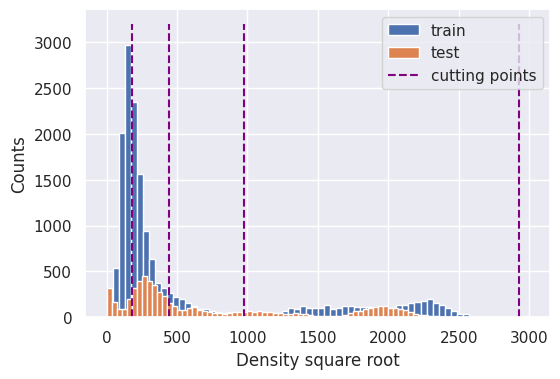

In [344]:
plt.figure(figsize=(6,4))
plt.hist(np.clip(trPprobs,0,3000) ,70, label='train')
plt.hist(np.clip(tePprobs,0,3000) ,70, label='test')

# plt.hist(trPprobs ,70)

# plt.axvline(x=coefficients[1], )
plt.vlines(x=coefficients, ymin=0, ymax=3200, colors='purple', ls='--', lw=1.5, label='cutting points')
plt.legend()
plt.ylabel('Counts')
plt.xlabel('Density square root')
plt.show()